In [13]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
%matplotlib inline


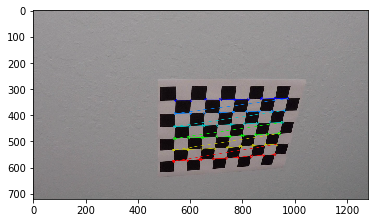

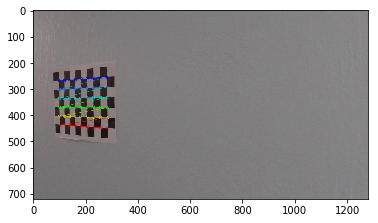

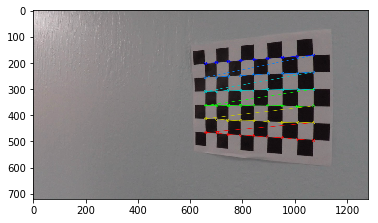

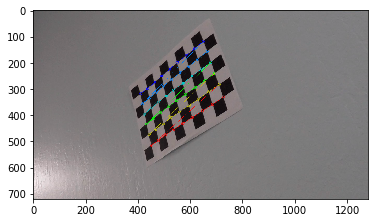

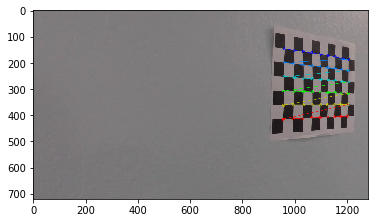

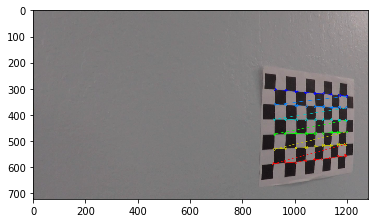

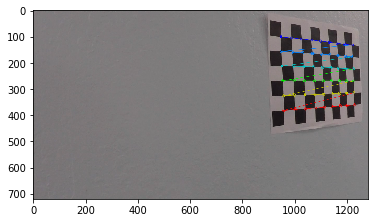

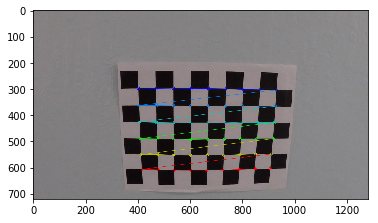

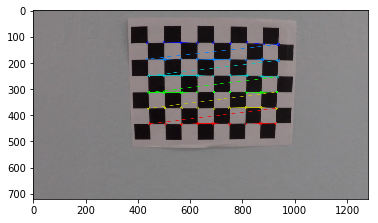

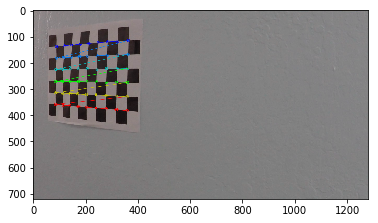

In [14]:
### CAMERA CALIBRATION
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration1*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
        write_name = './output_images/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, image)
        plt.figure()
        plt.imshow(image)


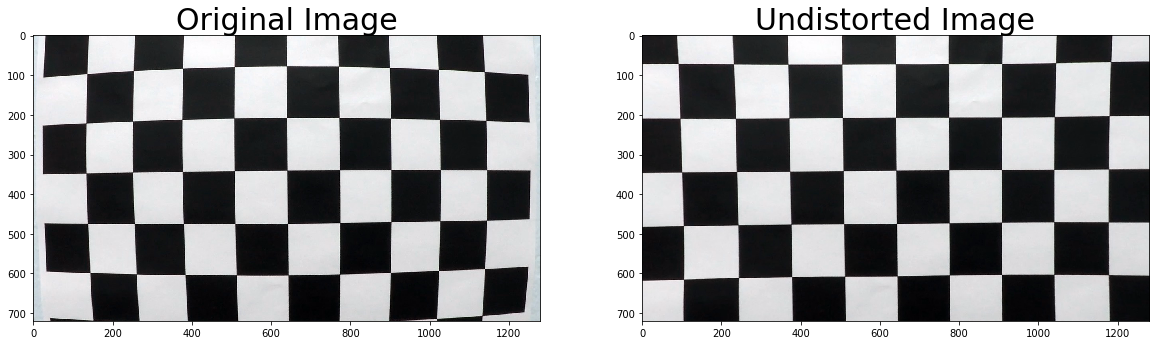

In [15]:
### Get undistorted image and Coefficients
import pickle
%matplotlib inline

# Test undistortion on an image
image = cv2.imread('camera_cal/calibration1.jpg')
img_size = (image.shape[1], image.shape[0])
# print(img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [16]:
## Perspective Transform
import matplotlib.patches as patches

def warp(img):
    # print(corners)
    c1 = (582, 460)
    c2 = (702, 460)
    c3 = (1065, 695)
    c4 = (252, 695)
    src = np.float32([c1, c2, c3, c4])
    # print(src)
    x = img.shape[1]
    y = img.shape[0]
#     print(gray.shape)
    d1 = [300, 0]
    d2 = [x - 300, 0]
    d3 = [x - 300, y]
    d4 = [300, y]

    dst = np.float32([d1, d2, d3, d4])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, (x, y))
    
############################################################
### UNCOMMENT THIS SECTION IF WE WANT TO DISPLAY 
### THE WARPED IMAGE WITH TRANSFORM BOXES
############################################################
#     plt.figure()
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.plot(c1[0], c1[1], 'x')
#     ax1.plot(c2[0], c2[1], 'x')
#     ax1.plot(c3[0], c3[1], 'x')
#     ax1.plot(c4[0], c4[1], 'x')
#     ax1.plot(d1[0], d1[1], 'o')
#     ax1.plot(d2[0], d2[1], 'o')
#     ax1.plot(d3[0], d3[1], 'o')
#     ax1.plot(d4[0], d4[1], 'o')
#     polygon = plt.Polygon(src, fill=None, edgecolor='r')
#     ax1.add_patch(polygon) 
#     polygonwarp = plt.Polygon(dst, fill=None, edgecolor='r')
#     ax2.add_patch(polygonwarp)
#     ax1.imshow(img)
#     ax1.set_title('Original Image with SRC/DST markers', fontsize=30)
#     ax2.imshow(warped)
#     ax2.set_title('Warped Image', fontsize=30)
    return warped, M

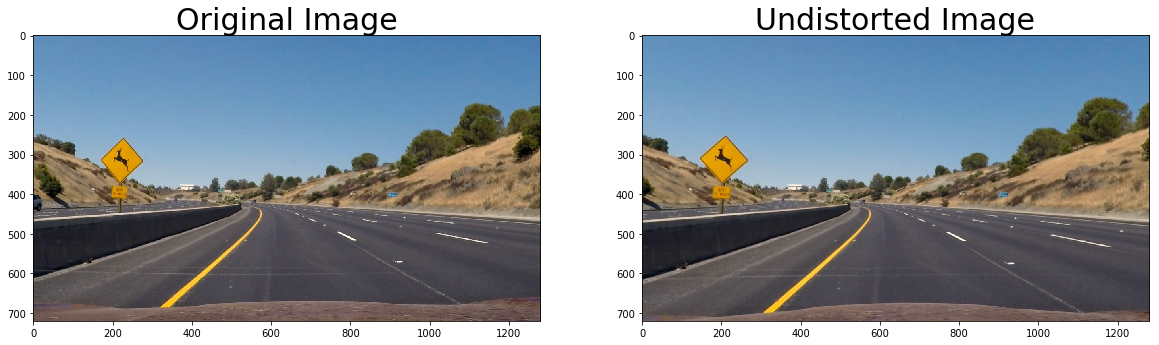

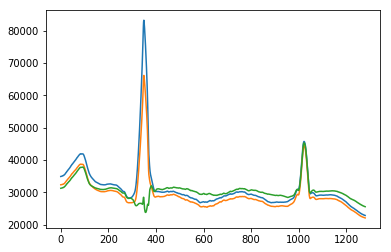

In [17]:
### Undistort and warp our images.
# Test our functions
image = mpimg.imread('test_images/test2.jpg')
und_img = cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(und_img)
ax2.set_title('Undistorted Image', fontsize=30)

und_warp, M = warp(und_img)
## Shiw histogram here
histogram = np.sum(und_warp[und_warp.shape[0]//2:,:], axis=0)
plt.figure()
plt.plot(histogram)


In [18]:

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

def color_threshold(img, s_thresh=(0, 255), h_thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary, h_binary

def get_binary(img):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    sx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(28, 70))
    s_binary, h_binary = color_threshold(img, h_thresh=(20, 100), s_thresh=(170,255))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 120))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    magdir = np.zeros_like(dir_binary)
    magdir[((mag_binary == 1) & (dir_binary == 1))] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sx_binary), s_binary, h_binary, magdir))
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (s_binary == 1) | (magdir == 1)] = 1 # 
    return color_binary, combined_binary, sx_binary, s_binary, h_binary, magdir, dir_binary, mag_binary
    
def plot_binaries(color, combination, sx_binary, s_binary, h_binary, magdir, dir_binary, mag_binary):
    # Plotting thresholded images
    plt.figure()
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(30,20))
    ax1.set_title('Sobel X thresholds')
    ax1.imshow(sx_binary, cmap='gray')
    ax2.set_title('s_binary')
    ax2.imshow(s_binary, cmap='gray')
    ax3.set_title('h_binary')
    ax3.imshow(h_binary, cmap='gray')
    ax4.set_title('Mag_binary')
    ax4.imshow(mag_binary, cmap='gray')
    ax5.set_title('dir_binary')
    ax5.imshow(dir_binary, cmap='gray')
    ax6.set_title('Combined magnitude & Direction')
    ax6.imshow(magdir, cmap='gray')
    ax7.set_title('Combined S channel and gradient thresholds')
    ax7.imshow(combination, cmap='gray')
    ax8.set_title('Stacked thresholds')
    ax8.imshow(color)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



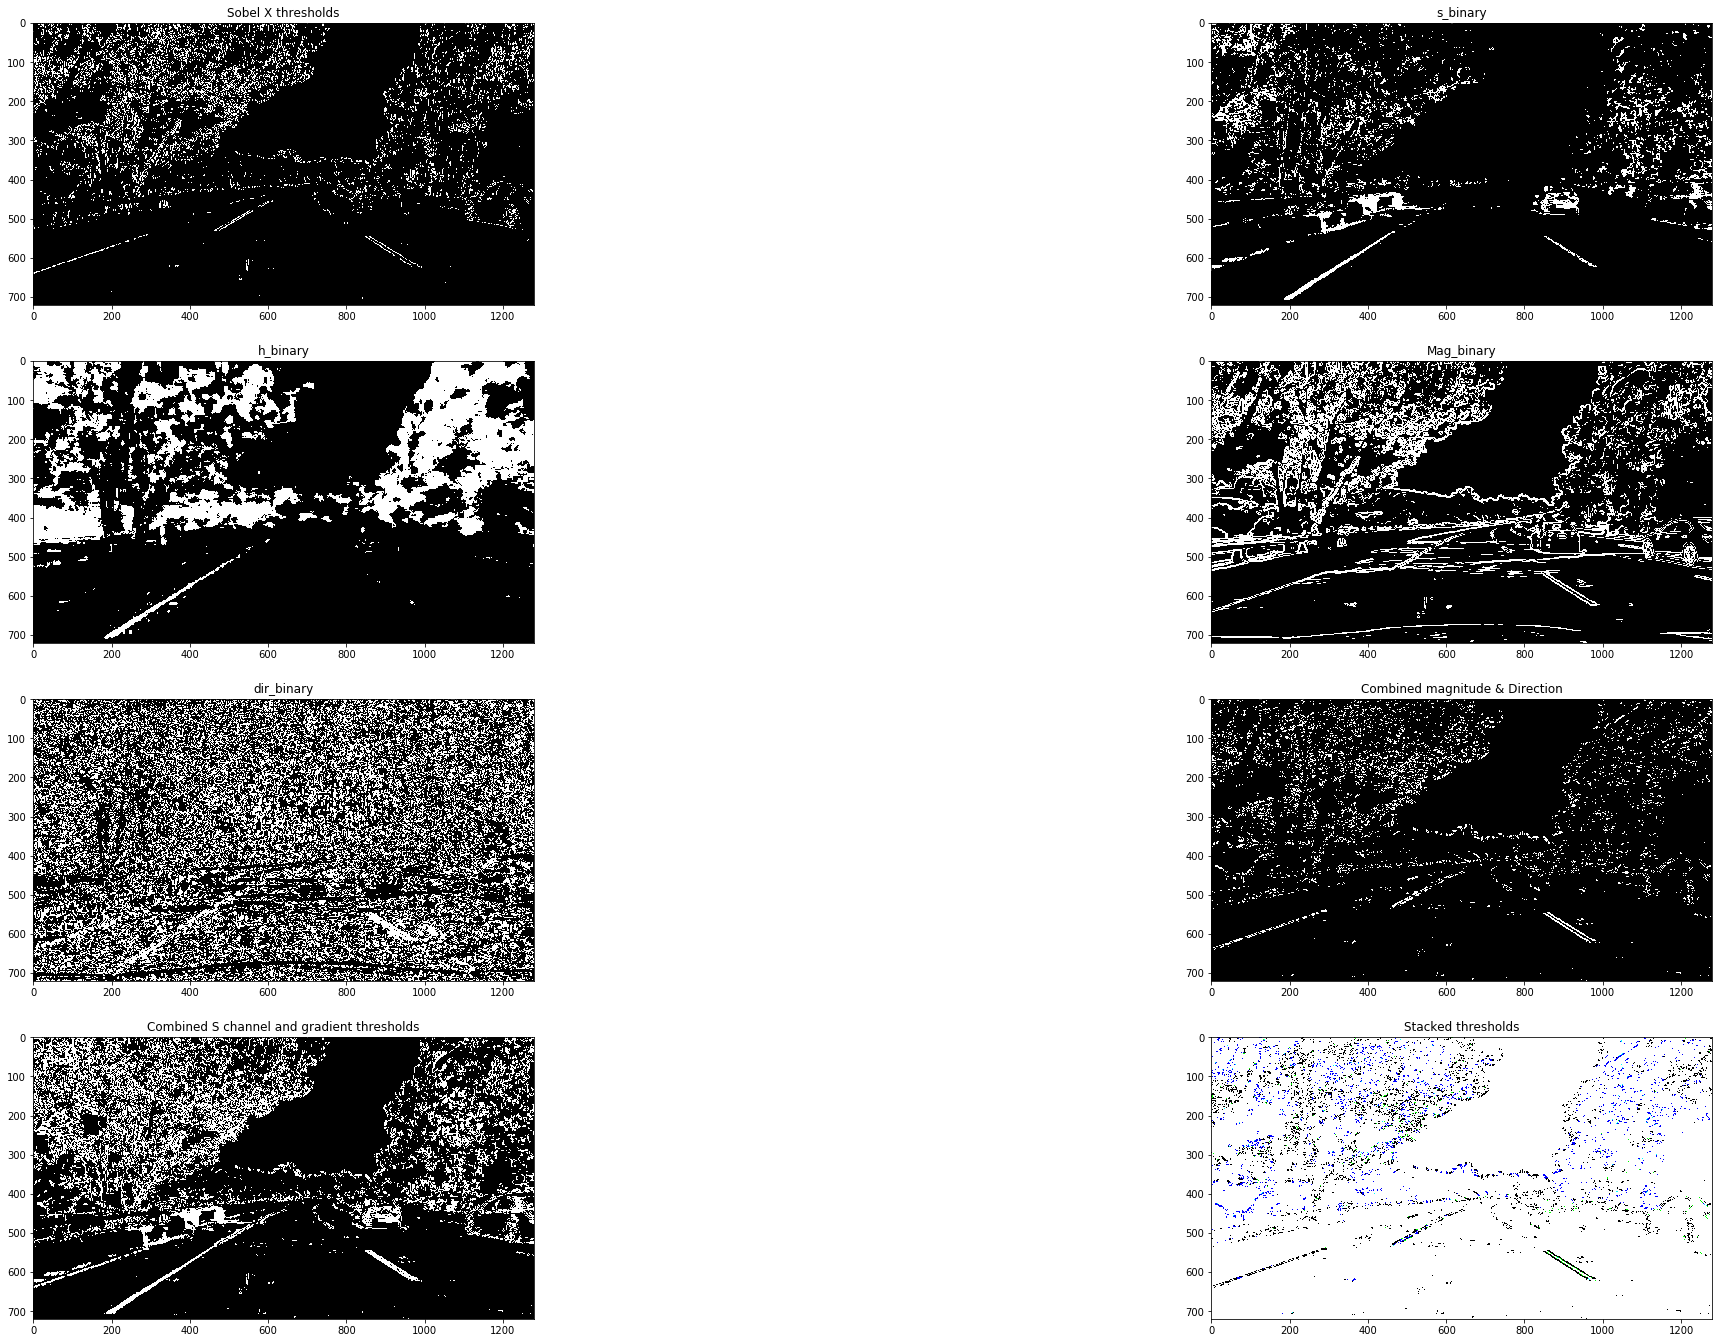

In [19]:
### Get the thresholding, warped and histogram of test images
test_image = mpimg.imread('test_images/test5.jpg')
und_test = cv2.undistort(test_image, mtx, dist, None, mtx)
col_binary, comb_binary, sxb1, sb1, hb1, md1, dir1, mag1 = get_binary(und_test)
plot_binaries(col_binary, comb_binary, sxb1, sb1, hb1, md1, dir1, mag1)
und_warp1, M1 = warp(comb_binary)


In [20]:
def plot_curve(img, left_x, right_x):
    plt.figure()
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
#     plt.scatter(rightx, righty)
    plt.imshow(img)
    plt.plot(left_x, ploty, color='yellow')
    plt.plot(right_x, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)   


def fit_lines(img, left_lane_inds, right_lane_inds):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ####################################
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#     print(left_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ####################################
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx

### This function takes an undistorted warped image
def moving_window(img):
    ### Create moving window to detec line curvature
    # Assuming you have created a warped binary image called "binary_warped"
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
#         plt.imshow(out_img)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Fit Lines based on data point indices
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_lane_inds, right_lane_inds, out_img

### This function takes in an undistorted warped image along with a previously fit polynomial 
def find_next(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
#     print('find left_fit: ', left_fit)
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

     # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_lane_inds, right_lane_inds, out_img

# This takes in an image, and two x,y arrays left/right[0] = x, left/right[1] = y
def get_radius(img, left, right):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    nzero = img.nonzero()
    nzeroy = np.array(nzero[0])
    nzerox = np.array(nzero[1])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space (left[1] = y, left[0] = x)
    left_fit_cr = np.polyfit(left[1]*ym_per_pix, left[0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right[1]*ym_per_pix, right[0]*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return [left_curverad, right_curverad]
    
def get_offset(img, left_fitx, right_fitx):
    h = img.shape[0]
    l = h**2*left_fitx[0] + h*left_fitx[1] + left_fitx[2]
    r = h**2*right_fitx[0] + h*right_fitx[1] + right_fitx[2]
    center = img.shape[1]/2
    center_x = (center - ((r - l)/2 + l)) * 3.7/700
    return center_x

def draw_lane(undist, warped, left_x, right_x, M, offset, radius):
    Minv = np.linalg.inv(M)
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0] )
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
#     cv2.putText(result,'Radius of curvature left = %.3f(m), right= %.3f(m)' % (radius[0], radius[1]),(12,90), font, 1,(255,255,255),3)
    avg_radius = (radius[0]+radius[1])/2
    cv2.putText(result,'Radius of curvature avg = %.3f(m)' % avg_radius,(12,135), font, 1,(255,255,255),3)
    if offset > 0:
        cv2.putText(result,'Vehicle is %.3fm right of center' % np.abs(offset),(12,45), font,1,(255,255,255),3)
    if offset < 0:
        cv2.putText(result,'Vehicle is %.3fm left of center' % np.abs(offset),(12,45), font,1,(255,255,255),3)
    if offset == 0:
        cv2.putText(result,'Vehicle is centered',(12,45), font,1,(255,255,255),3)

    return result

def check_parallel(left_fitx, right_fitx, left_fit, right_fit):
    parallel = True
    diff = []
    for x_l, x_r in zip(left_fitx, right_fitx):
        d = x_r - x_l
        diff.append(d)
        if d > 800 or d < 550:
            parallel = False
            
    if parallel == False:
        print('Lane width out of bounds')
    
    if (left_fit[0] > 0 and right_fit[0] < 0) | (left_fit[0] < 0 and right_fit[0] > 0):
        print('Lane curves don\'t match')
        print('left: ',left_fit)
        print('right: ' , right_fit)
        parallel = False
    return parallel, diff



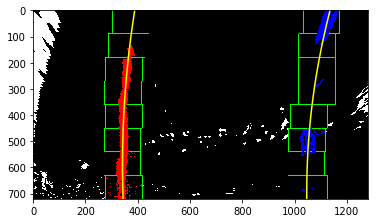

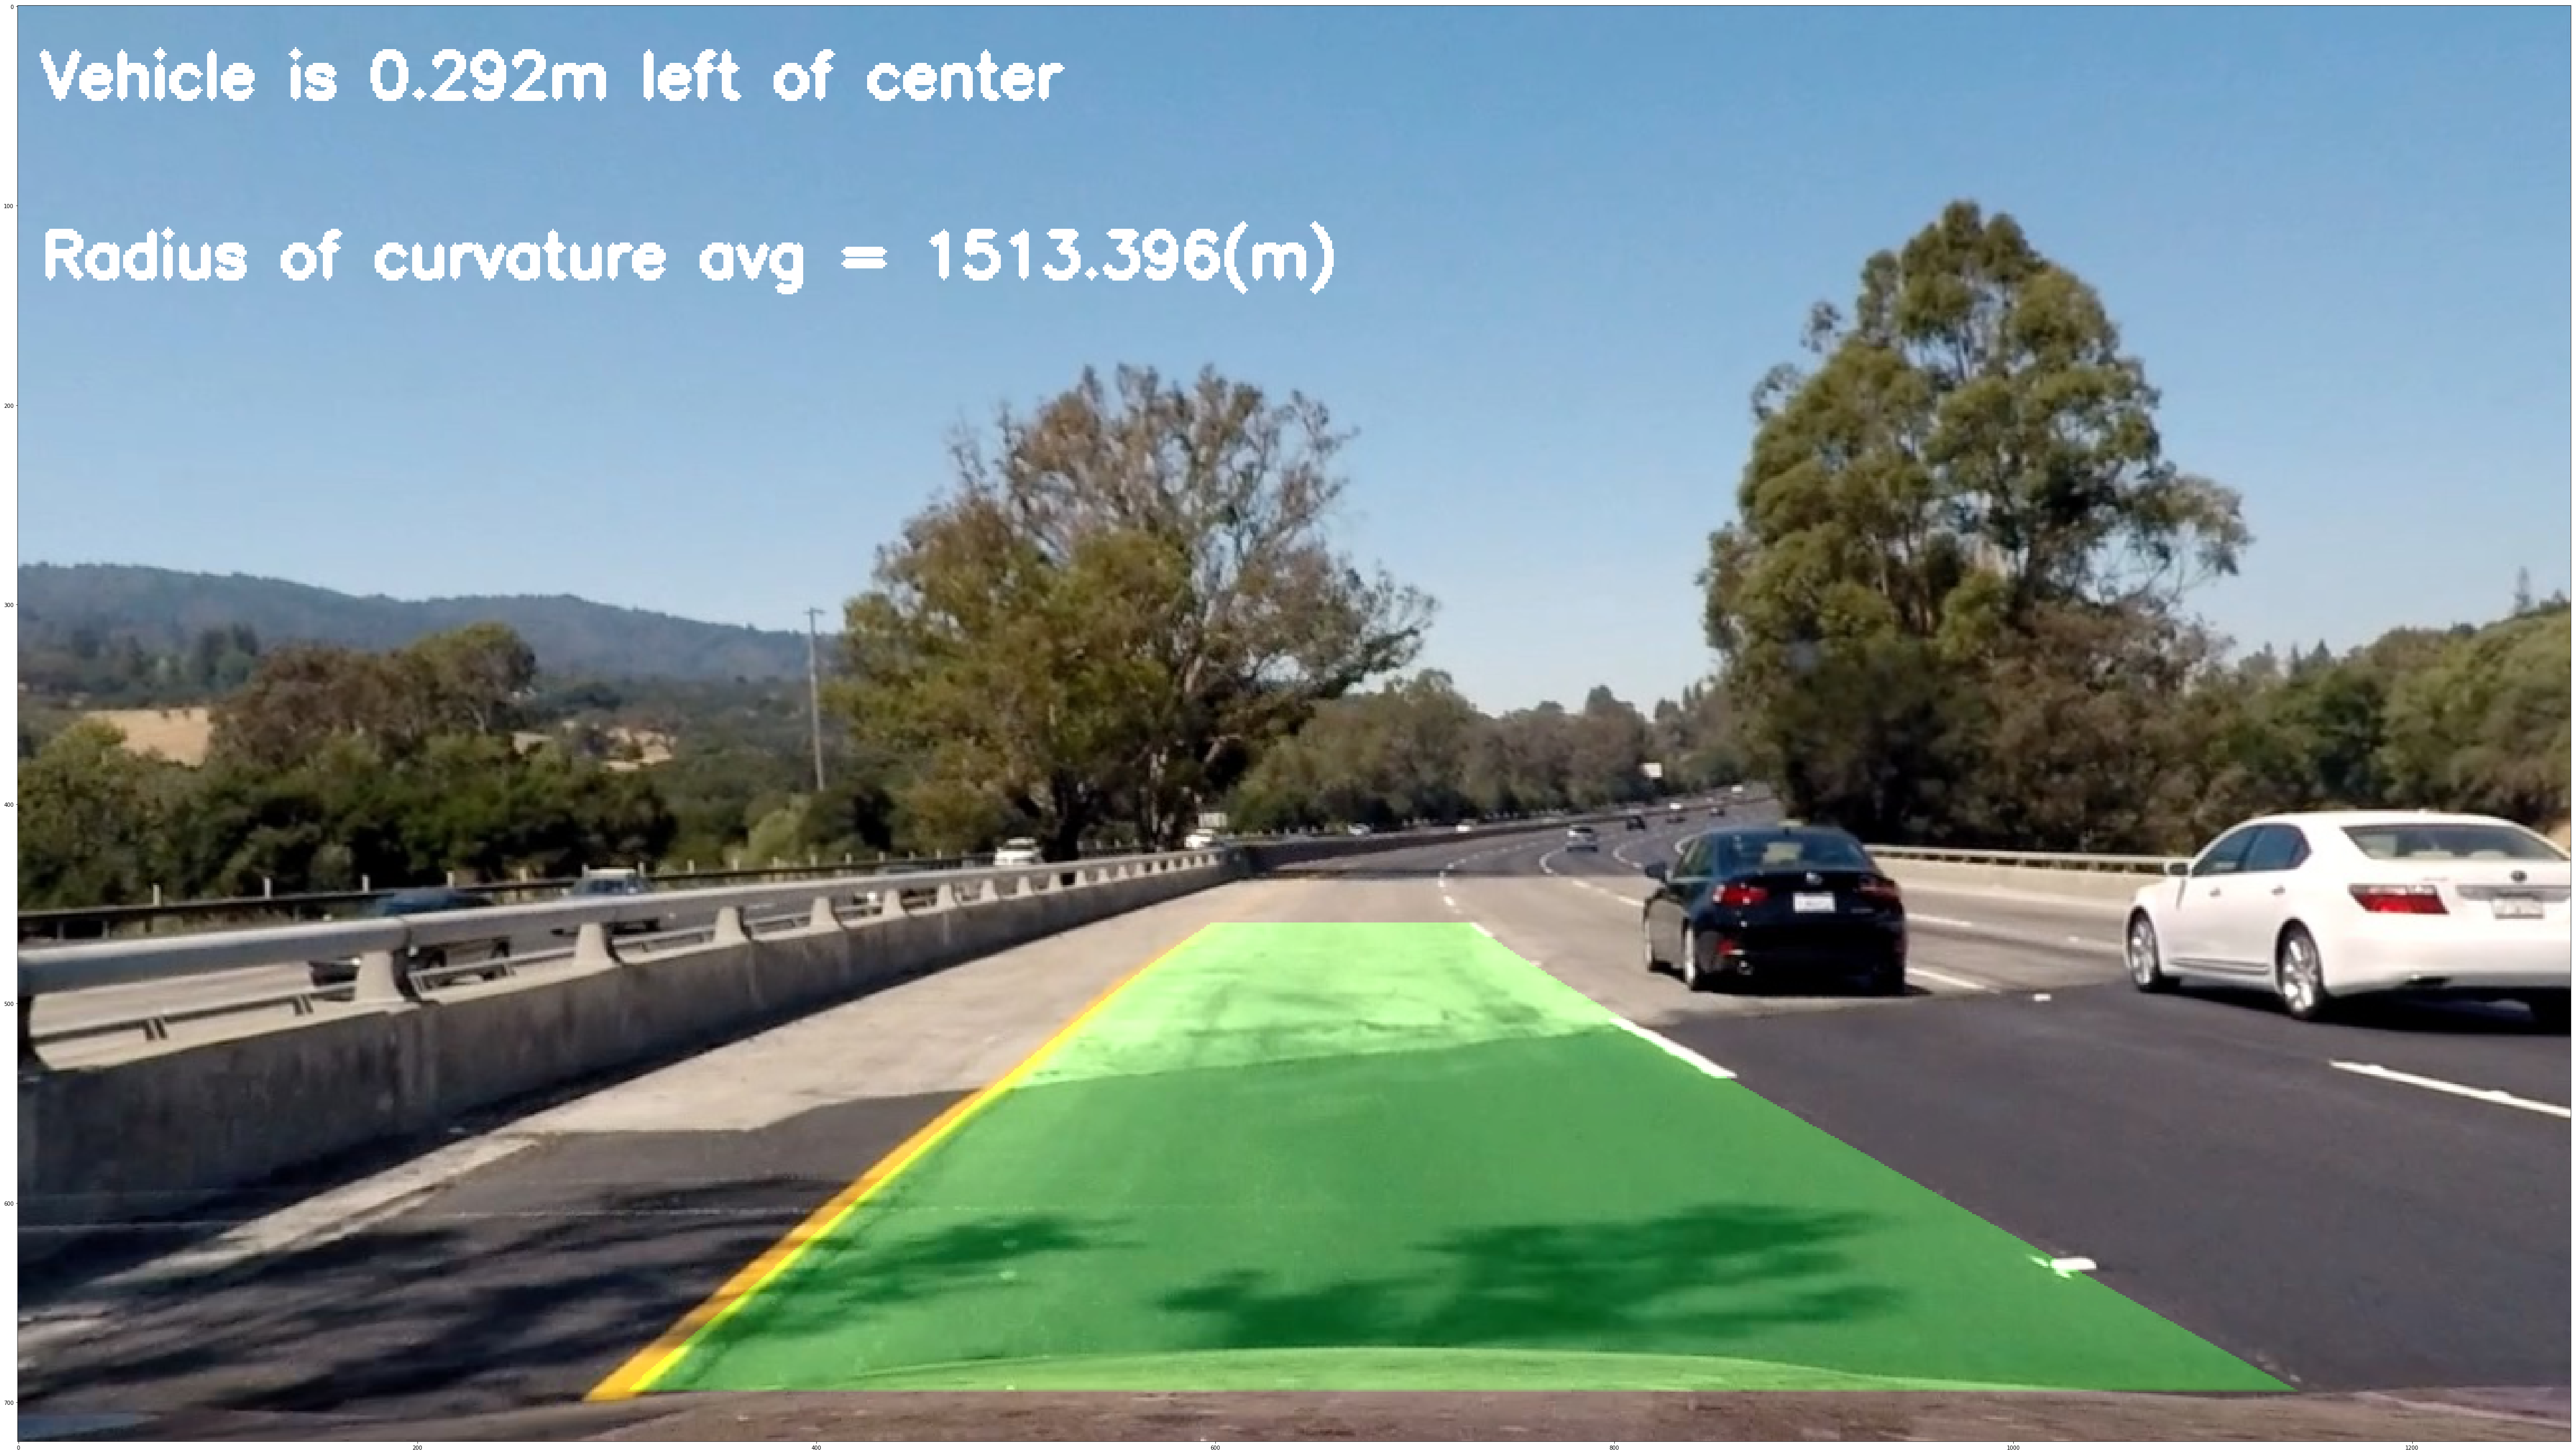

In [21]:
### Get the thresholding, warped and histogram of test images
test_image = mpimg.imread('test_images/test4.jpg')
und_test = cv2.undistort(test_image, mtx, dist, None, mtx)

col_binary, comb_binary, sxb1, sb1, hb1, md1, dir1, mag1 = get_binary(und_test)
und_warp1, M = warp(comb_binary)

left_ind, right_ind, out_img = moving_window(und_warp1)
leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx = fit_lines(und_warp1, left_ind, right_ind)
curvature = get_radius(und_warp1, [leftx, lefty], [rightx, righty])

plot_curve(out_img, left_fitx, right_fitx)

offset1 = get_offset(und_warp1, left_fit, right_fit)
lane_img = draw_lane(und_test, und_warp1, left_fitx, right_fitx, M, offset1, curvature)
plt.figure(figsize=(100,50))
plt.imshow(lane_img)
parallel, diff = check_parallel(left_fitx, right_fitx, left_fit, right_fit)



In [96]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #radius of curvature of the line in some units
        self.curvature = [np.array([False])]   
        #fitted lines for each curve
        self.curr_left_fit = [np.array([False])] 
        self.curr_right_fit = [np.array([False])] 
        #best fitted line for each curve
        self.best_left_fit = np.array([False])
        self.best_right_fit = np.array([False])
        #average x values of the fitted line over the last n iterations
        self.best_left_x = None
        self.best_right_x = None
        #x values of the last n fits of the line
        self.recent_left_x = []
        self.recent_right_x = []
        # Max number of frames to use for averaging
        self.max_n = 5
        # Number of bad frames and max total before using sliding window searching again.
        self.bad_frames = 0
        self.max_bad = 5

        #x values for detected line pixels
        self.left_allx = []  
        self.right_allx = []
        #y values for detected line pixels
        self.left_ally = []
        self.right_ally = []
        
    def get_best_left_fit(self):
        leftallx = np.concatenate(self.left_allx)
        leftally = np.concatenate(self.left_ally)
        return np.polyfit(leftally, leftallx, 2)
    
    def get_best_right_fit(self):
        rightallx = np.concatenate(self.right_allx)
        rightally = np.concatenate(self.right_ally)
        return np.polyfit(rightally, rightallx, 2)
        
    def add_leftx(self, leftx = None, lefty = None):
        if len(self.left_allx) >= self.max_n:
            self.left_allx.pop(0)
            self.left_ally.pop(0)
        self.left_allx.append(leftx)
        self.left_ally.append(lefty)

    def add_rightx(self, rightx, righty):
        if len(self.right_allx) >= self.max_n:
            self.right_allx.pop(0)
            self.right_ally.pop(0)
        self.right_allx.append(rightx)
        self.right_ally.append(righty)

    def getBest_left(self):
        if len(self.recent_left_x) >= self.max_n:
            self.recent_left_x.pop(0)
        return np.average(self.recent_left_x, axis=0)
    def getBest_right(self):
        if len(self.recent_right_x) >= self.max_n:
            self.recent_right_x.pop(0)
        return np.average(self.recent_right_x, axis=0)

In [97]:
lines = Line()

In [98]:
# Sanity Check 
#similar curvature?
#Correct distance between the lines
def sanity_check(undestorted_warp, left_fitx, right_fitx, left_fit, right_fit):
    #the lanes are parallel
    prll, diffs = check_parallel(left_fitx, right_fitx, left_fit, right_fit)
    return prll, diffs

In [99]:

def process_image(image):
    g_frame = len(os.listdir("output_images/test/")) + 1
    ### Get the thresholding, warped and histogram of test images
    undestorted = cv2.undistort(image, mtx, dist, None, mtx)
    col_binary, comb_binary, sxb1, sb1, hb1, md1, dir1, mag1 = get_binary(undestorted)
    undestorted_warp, M = warp(comb_binary)           

    # If we haven't found a line yet, use the moving window, otherwise look around previous line for next line.
    if lines.detected == False:
        print('moving window')
        left_ind, right_ind, out_img = moving_window(undestorted_warp)   
    else:
        print('find_next')
        left_ind, right_ind, out_img = find_next(undestorted_warp, lines.get_best_left_fit(), lines.get_best_right_fit()) # Modify this to use previous fit
    
    # Fit the detected lines to a curve and get helpful variables
    leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx = fit_lines(undestorted_warp, left_ind, right_ind)

    plot_curve(out_img, left_fitx, right_fitx)
    
    # Do a sanity check to make sure the lines are good before saving them 
    parallel, linediff = sanity_check(undestorted_warp, left_fitx, right_fitx, left_fit, right_fit)
    if parallel:
        # Sanity check passes:
        # Add and save new lines to our list    
        lines.curr_left_fit = left_fit
        lines.curr_right_fit = right_fit
        # Add to moving average (remove oldest frame, add newest frame)
        lines.recent_left_x.append(left_fitx)
        lines.recent_right_x.append(right_fitx)
        ## Remove oldest data set (Maybe use N count)
        lines.best_left_x = lines.getBest_left() 
        lines.best_right_x = lines.getBest_right() 
        # Add pixel points
        lines.add_leftx(leftx, lefty)
        lines.add_rightx(rightx, righty)
    #     print('length of left_allx: ', len(lines.left_allx))
        lines.detected = True #if everything passes the sanity checkS
        
#         print('best fit: ', lines.get_best_left_fit())
#         print('left_fit: ', left_fit)
    
    else:
        lines.bad_frames += 1
       
    # If we have too many bad frames, set to false so we can redo moving window search
    if lines.bad_frames >= lines.max_bad:
        lines.detected = False
        lines.bad_frames = 0
#     print('Bad frames: ', lines.bad_frames)
    
    # Get Curvature and offset of the smoothed line
    leftallx = np.concatenate(lines.left_allx)
    leftally = np.concatenate(lines.left_ally)
    rightallx = np.concatenate(lines.right_allx)
    rightally = np.concatenate(lines.right_ally)
    curvature = get_radius(undestorted_warp, [leftallx, leftally], [rightallx, rightally])
    offset = get_offset(undestorted_warp, lines.get_best_left_fit(), lines.get_best_right_fit())        
    lines.curvature = curvature
    
    # Draw the smoothed line
    lane_img = draw_lane(undestorted, undestorted_warp, lines.best_left_x, lines.best_right_x, M, offset, curvature)
    
    return lane_img


In [100]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [101]:
video_output = 'output_images/project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

moving window
[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<08:17,  2.53it/s]

find_next




  0%|          | 2/1261 [00:00<08:31,  2.46it/s]

find_next




  0%|          | 3/1261 [00:01<09:15,  2.26it/s]

find_next




  0%|          | 4/1261 [00:01<09:08,  2.29it/s]

find_next




  0%|          | 5/1261 [00:02<09:00,  2.32it/s]

find_next




  0%|          | 6/1261 [00:02<08:56,  2.34it/s]

find_next




  1%|          | 7/1261 [00:03<09:19,  2.24it/s]

find_next




  1%|          | 8/1261 [00:03<09:08,  2.28it/s]

find_next
Lane curves don't match
left:  [ -2.43916646e-04   3.53389387e-01   2.32487427e+02]
right:  [  9.15780846e-05   1.65202251e-01   9.20406379e+02]




  1%|          | 9/1261 [00:03<09:03,  2.30it/s]

find_next
Lane curves don't match
left:  [ -2.42414641e-04   3.58059775e-01   2.28196677e+02]
right:  [  1.51204262e-04   1.21497589e-01   9.28583148e+02]




  1%|          | 10/1261 [00:04<08:58,  2.32it/s]

find_next
Lane curves don't match
left:  [ -2.35268822e-04   3.56395014e-01   2.25969765e+02]
right:  [  8.63655500e-05   1.57096581e-01   9.24019009e+02]




  1%|          | 11/1261 [00:04<08:52,  2.35it/s]

find_next




  1%|          | 12/1261 [00:05<09:10,  2.27it/s]

find_next




  1%|          | 13/1261 [00:05<09:16,  2.24it/s]

find_next




  1%|          | 14/1261 [00:06<09:00,  2.31it/s]

find_next




  1%|          | 15/1261 [00:06<08:50,  2.35it/s]

find_next




  1%|▏         | 16/1261 [00:06<08:43,  2.38it/s]

find_next




  1%|▏         | 17/1261 [00:07<08:41,  2.39it/s]

find_next




  1%|▏         | 18/1261 [00:07<09:01,  2.30it/s]

find_next




  2%|▏         | 19/1261 [00:08<08:56,  2.31it/s]

find_next




  2%|▏         | 20/1261 [00:08<08:43,  2.37it/s]

find_next




  2%|▏         | 21/1261 [00:09<08:31,  2.42it/s]

find_next
Lane curves don't match
left:  [ -1.33325106e-04   2.92197040e-01   2.16981805e+02]
right:  [  8.93081147e-05   1.93838242e-01   8.97231976e+02]




  2%|▏         | 22/1261 [00:09<08:26,  2.44it/s]

find_next
Lane curves don't match
left:  [ -1.27134932e-04   2.88368536e-01   2.14239967e+02]
right:  [  2.96862936e-06   2.39141588e-01   8.97136555e+02]




  2%|▏         | 23/1261 [00:09<08:25,  2.45it/s]

moving window
Lane curves don't match
left:  [ -1.38181205e-04   2.99640392e-01   2.08576994e+02]
right:  [  1.62167335e-04   8.93038903e-02   9.32508503e+02]




  2%|▏         | 24/1261 [00:10<08:21,  2.47it/s]

moving window




  2%|▏         | 25/1261 [00:10<08:24,  2.45it/s]

find_next




  2%|▏         | 26/1261 [00:11<08:27,  2.43it/s]

find_next




  2%|▏         | 27/1261 [00:11<08:33,  2.40it/s]

find_next




  2%|▏         | 28/1261 [00:11<08:38,  2.38it/s]

find_next




  2%|▏         | 29/1261 [00:12<08:37,  2.38it/s]

find_next




  2%|▏         | 30/1261 [00:12<08:37,  2.38it/s]

find_next




  2%|▏         | 31/1261 [00:13<08:27,  2.43it/s]

find_next




  3%|▎         | 32/1261 [00:13<08:28,  2.42it/s]

find_next




  3%|▎         | 33/1261 [00:13<08:24,  2.44it/s]

find_next




  3%|▎         | 34/1261 [00:14<08:26,  2.42it/s]

find_next
Lane curves don't match
left:  [ -2.38621947e-04   3.35631836e-01   2.22077552e+02]
right:  [  1.32943119e-04   1.53444982e-01   9.09853941e+02]




  3%|▎         | 35/1261 [00:14<08:32,  2.39it/s]

find_next
Lane curves don't match
left:  [ -2.48619161e-04   3.44913690e-01   2.21562834e+02]
right:  [  1.78924313e-05   2.09998238e-01   9.06568742e+02]




  3%|▎         | 36/1261 [00:15<08:34,  2.38it/s]

find_next




  3%|▎         | 37/1261 [00:15<08:28,  2.41it/s]

find_next




  3%|▎         | 38/1261 [00:16<08:23,  2.43it/s]

find_next




  3%|▎         | 39/1261 [00:16<08:26,  2.41it/s]

find_next




  3%|▎         | 40/1261 [00:16<08:32,  2.38it/s]

find_next




  3%|▎         | 41/1261 [00:17<08:37,  2.36it/s]

find_next




  3%|▎         | 42/1261 [00:17<08:46,  2.32it/s]

find_next




  3%|▎         | 43/1261 [00:18<08:38,  2.35it/s]

find_next




  3%|▎         | 44/1261 [00:18<08:43,  2.32it/s]

find_next




  4%|▎         | 45/1261 [00:19<08:43,  2.32it/s]

find_next




  4%|▎         | 46/1261 [00:19<08:39,  2.34it/s]

find_next




  4%|▎         | 47/1261 [00:19<08:36,  2.35it/s]

find_next




  4%|▍         | 48/1261 [00:20<08:39,  2.33it/s]

find_next




  4%|▍         | 49/1261 [00:20<08:33,  2.36it/s]

find_next




  4%|▍         | 50/1261 [00:21<08:30,  2.37it/s]

find_next




  4%|▍         | 51/1261 [00:21<08:33,  2.36it/s]

find_next




  4%|▍         | 52/1261 [00:22<08:35,  2.34it/s]

find_next




  4%|▍         | 53/1261 [00:22<08:36,  2.34it/s]

find_next




  4%|▍         | 54/1261 [00:22<08:33,  2.35it/s]

find_next




  4%|▍         | 55/1261 [00:23<08:35,  2.34it/s]

find_next




  4%|▍         | 56/1261 [00:23<08:40,  2.31it/s]

find_next




  5%|▍         | 57/1261 [00:24<08:28,  2.37it/s]

find_next




  5%|▍         | 58/1261 [00:24<08:27,  2.37it/s]

find_next




  5%|▍         | 59/1261 [00:25<08:21,  2.40it/s]

find_next




  5%|▍         | 60/1261 [00:25<08:35,  2.33it/s]

find_next




  5%|▍         | 61/1261 [00:25<08:42,  2.30it/s]

find_next




  5%|▍         | 62/1261 [00:26<08:41,  2.30it/s]

find_next




  5%|▍         | 63/1261 [00:26<08:30,  2.35it/s]

find_next




  5%|▌         | 64/1261 [00:27<08:26,  2.36it/s]

find_next




  5%|▌         | 65/1261 [00:27<08:18,  2.40it/s]

find_next




  5%|▌         | 66/1261 [00:27<08:14,  2.42it/s]

find_next




  5%|▌         | 67/1261 [00:28<08:13,  2.42it/s]

find_next




  5%|▌         | 68/1261 [00:28<08:09,  2.44it/s]

find_next




  5%|▌         | 69/1261 [00:29<08:17,  2.39it/s]

find_next




  6%|▌         | 70/1261 [00:29<08:22,  2.37it/s]

find_next




  6%|▌         | 71/1261 [00:30<08:21,  2.37it/s]

find_next




  6%|▌         | 72/1261 [00:30<08:28,  2.34it/s]

find_next




  6%|▌         | 73/1261 [00:30<08:24,  2.36it/s]

find_next




  6%|▌         | 74/1261 [00:31<08:29,  2.33it/s]

find_next




  6%|▌         | 75/1261 [00:31<08:26,  2.34it/s]

find_next




  6%|▌         | 76/1261 [00:32<08:39,  2.28it/s]

find_next




  6%|▌         | 77/1261 [00:32<08:44,  2.26it/s]

find_next




  6%|▌         | 78/1261 [00:33<08:53,  2.22it/s]

find_next




  6%|▋         | 79/1261 [00:33<08:54,  2.21it/s]

find_next




  6%|▋         | 80/1261 [00:34<08:53,  2.21it/s]

find_next




  6%|▋         | 81/1261 [00:34<08:46,  2.24it/s]

find_next




  7%|▋         | 82/1261 [00:34<08:42,  2.26it/s]

find_next




  7%|▋         | 83/1261 [00:35<08:36,  2.28it/s]

find_next




  7%|▋         | 84/1261 [00:35<08:43,  2.25it/s]

find_next




  7%|▋         | 85/1261 [00:36<08:43,  2.25it/s]

find_next




  7%|▋         | 86/1261 [00:36<08:42,  2.25it/s]

find_next




  7%|▋         | 87/1261 [00:37<08:43,  2.24it/s]

find_next




  7%|▋         | 88/1261 [00:37<09:12,  2.12it/s]

find_next




  7%|▋         | 89/1261 [00:38<08:57,  2.18it/s]

find_next




  7%|▋         | 90/1261 [00:38<08:55,  2.19it/s]

find_next




  7%|▋         | 91/1261 [00:39<08:45,  2.23it/s]

find_next




  7%|▋         | 92/1261 [00:39<08:48,  2.21it/s]

find_next




  7%|▋         | 93/1261 [00:39<08:43,  2.23it/s]

find_next




  7%|▋         | 94/1261 [00:40<08:38,  2.25it/s]

find_next




  8%|▊         | 95/1261 [00:40<08:33,  2.27it/s]

find_next




  8%|▊         | 96/1261 [00:41<09:04,  2.14it/s]

find_next
Lane curves don't match
left:  [ -2.54642324e-04   3.22967647e-01   2.21561931e+02]
right:  [  1.02070966e-04   1.76247748e-01   8.77048361e+02]




  8%|▊         | 97/1261 [00:41<09:01,  2.15it/s]

find_next




  8%|▊         | 98/1261 [00:42<08:57,  2.16it/s]

find_next




  8%|▊         | 99/1261 [00:42<08:47,  2.20it/s]

find_next




  8%|▊         | 100/1261 [00:43<08:44,  2.21it/s]

find_next




  8%|▊         | 101/1261 [00:43<08:43,  2.22it/s]

find_next




  8%|▊         | 102/1261 [00:44<08:34,  2.25it/s]

find_next




  8%|▊         | 103/1261 [00:44<08:24,  2.29it/s]

find_next




  8%|▊         | 104/1261 [00:44<08:23,  2.30it/s]

find_next




  8%|▊         | 105/1261 [00:45<08:15,  2.33it/s]

find_next




  8%|▊         | 106/1261 [00:45<08:11,  2.35it/s]

find_next




  8%|▊         | 107/1261 [00:46<08:20,  2.30it/s]

find_next




  9%|▊         | 108/1261 [00:46<08:20,  2.30it/s]

find_next




  9%|▊         | 109/1261 [00:47<08:17,  2.32it/s]

find_next




  9%|▊         | 110/1261 [00:47<08:25,  2.28it/s]

find_next




  9%|▉         | 111/1261 [00:47<08:31,  2.25it/s]

find_next




  9%|▉         | 112/1261 [00:48<08:41,  2.20it/s]

find_next




  9%|▉         | 113/1261 [00:48<08:49,  2.17it/s]

find_next




  9%|▉         | 114/1261 [00:49<08:47,  2.17it/s]

find_next




  9%|▉         | 115/1261 [00:49<08:45,  2.18it/s]

find_next




  9%|▉         | 116/1261 [00:50<08:51,  2.15it/s]

find_next




  9%|▉         | 117/1261 [00:50<08:52,  2.15it/s]

find_next




  9%|▉         | 118/1261 [00:51<08:38,  2.20it/s]

find_next




  9%|▉         | 119/1261 [00:51<08:34,  2.22it/s]

find_next




 10%|▉         | 120/1261 [00:52<08:24,  2.26it/s]

find_next




 10%|▉         | 121/1261 [00:52<08:25,  2.26it/s]

find_next




 10%|▉         | 122/1261 [00:52<08:23,  2.26it/s]

find_next




 10%|▉         | 123/1261 [00:53<08:41,  2.18it/s]

find_next




 10%|▉         | 124/1261 [00:53<08:34,  2.21it/s]

find_next




 10%|▉         | 125/1261 [00:54<08:37,  2.20it/s]

find_next




 10%|▉         | 126/1261 [00:54<08:42,  2.17it/s]

find_next




 10%|█         | 127/1261 [00:55<08:41,  2.18it/s]

find_next




 10%|█         | 128/1261 [00:55<08:42,  2.17it/s]

find_next




 10%|█         | 129/1261 [00:56<08:37,  2.19it/s]

find_next




 10%|█         | 130/1261 [00:56<08:37,  2.19it/s]

find_next




 10%|█         | 131/1261 [00:57<08:32,  2.20it/s]

find_next




 10%|█         | 132/1261 [00:57<08:26,  2.23it/s]

find_next




 11%|█         | 133/1261 [00:57<08:22,  2.24it/s]

find_next




 11%|█         | 134/1261 [00:58<08:19,  2.26it/s]

find_next




 11%|█         | 135/1261 [00:58<08:11,  2.29it/s]

find_next




 11%|█         | 136/1261 [00:59<08:07,  2.31it/s]

find_next




 11%|█         | 137/1261 [00:59<08:04,  2.32it/s]

find_next




 11%|█         | 138/1261 [01:00<08:04,  2.32it/s]

find_next




 11%|█         | 139/1261 [01:00<08:04,  2.32it/s]

find_next


find_next




 11%|█         | 140/1261 [01:01<09:38,  1.94it/s]

find_next




 11%|█         | 141/1261 [01:02<12:06,  1.54it/s]

 11%|█▏        | 142/1261 [01:02<11:12,  1.66it/s]

find_next




 11%|█▏        | 143/1261 [01:03<10:23,  1.79it/s]

find_next




 11%|█▏        | 144/1261 [01:03<10:04,  1.85it/s]

find_next




 11%|█▏        | 145/1261 [01:04<09:47,  1.90it/s]

find_next




 12%|█▏        | 146/1261 [01:04<09:32,  1.95it/s]

find_next




 12%|█▏        | 147/1261 [01:05<09:30,  1.95it/s]

find_next




 12%|█▏        | 148/1261 [01:05<09:26,  1.97it/s]

find_next




 12%|█▏        | 149/1261 [01:06<09:11,  2.02it/s]

find_next




 12%|█▏        | 150/1261 [01:06<08:59,  2.06it/s]

find_next




 12%|█▏        | 151/1261 [01:06<08:50,  2.09it/s]

find_next




 12%|█▏        | 152/1261 [01:07<08:42,  2.12it/s]

find_next




 12%|█▏        | 153/1261 [01:07<08:42,  2.12it/s]

find_next




 12%|█▏        | 154/1261 [01:08<08:45,  2.11it/s]

find_next




 12%|█▏        | 155/1261 [01:08<08:45,  2.10it/s]

find_next




 12%|█▏        | 156/1261 [01:09<08:42,  2.11it/s]

find_next




 12%|█▏        | 157/1261 [01:09<08:42,  2.11it/s]

find_next




 13%|█▎        | 158/1261 [01:10<08:47,  2.09it/s]

find_next




 13%|█▎        | 159/1261 [01:10<08:43,  2.10it/s]

find_next
Lane curves don't match
left:  [ -1.95875377e-04   3.05743374e-01   2.24621739e+02]
right:  [  8.58177739e-05   1.89464435e-01   8.95125041e+02]




 13%|█▎        | 160/1261 [01:11<08:21,  2.19it/s]

moving window




 13%|█▎        | 161/1261 [01:11<08:24,  2.18it/s]

find_next




 13%|█▎        | 162/1261 [01:12<08:24,  2.18it/s]

find_next




 13%|█▎        | 163/1261 [01:12<08:17,  2.21it/s]

find_next




 13%|█▎        | 164/1261 [01:12<08:12,  2.23it/s]

find_next




 13%|█▎        | 165/1261 [01:13<08:07,  2.25it/s]

find_next




 13%|█▎        | 166/1261 [01:13<08:11,  2.23it/s]

find_next




 13%|█▎        | 167/1261 [01:14<08:11,  2.22it/s]

find_next




 13%|█▎        | 168/1261 [01:14<08:16,  2.20it/s]

find_next




 13%|█▎        | 169/1261 [01:15<08:27,  2.15it/s]

find_next




 13%|█▎        | 170/1261 [01:15<08:36,  2.11it/s]

find_next




 14%|█▎        | 171/1261 [01:16<08:44,  2.08it/s]

find_next




 14%|█▎        | 172/1261 [01:16<08:46,  2.07it/s]

find_next




 14%|█▎        | 173/1261 [01:17<08:39,  2.10it/s]

find_next




 14%|█▍        | 174/1261 [01:17<08:31,  2.12it/s]

find_next




 14%|█▍        | 175/1261 [01:18<08:32,  2.12it/s]

find_next




 14%|█▍        | 176/1261 [01:18<08:29,  2.13it/s]

find_next




 14%|█▍        | 177/1261 [01:19<08:20,  2.17it/s]

find_next




 14%|█▍        | 178/1261 [01:19<08:14,  2.19it/s]

find_next




 14%|█▍        | 179/1261 [01:19<08:14,  2.19it/s]

find_next




 14%|█▍        | 180/1261 [01:20<08:13,  2.19it/s]

find_next




 14%|█▍        | 181/1261 [01:20<08:11,  2.20it/s]

find_next




 14%|█▍        | 182/1261 [01:21<08:10,  2.20it/s]

find_next




 15%|█▍        | 183/1261 [01:21<08:13,  2.18it/s]

find_next




 15%|█▍        | 184/1261 [01:22<08:18,  2.16it/s]

find_next




 15%|█▍        | 185/1261 [01:22<08:14,  2.17it/s]

find_next




 15%|█▍        | 186/1261 [01:23<08:17,  2.16it/s]

find_next




 15%|█▍        | 187/1261 [01:23<08:09,  2.20it/s]

find_next




 15%|█▍        | 188/1261 [01:24<08:17,  2.16it/s]

find_next




 15%|█▍        | 189/1261 [01:24<08:35,  2.08it/s]

find_next




 15%|█▌        | 190/1261 [01:25<08:34,  2.08it/s]

find_next




 15%|█▌        | 191/1261 [01:25<08:29,  2.10it/s]

find_next




 15%|█▌        | 192/1261 [01:26<08:25,  2.11it/s]

find_next




 15%|█▌        | 193/1261 [01:26<08:26,  2.11it/s]

find_next




 15%|█▌        | 194/1261 [01:27<08:28,  2.10it/s]

find_next




 15%|█▌        | 195/1261 [01:27<08:21,  2.12it/s]

find_next




 16%|█▌        | 196/1261 [01:27<08:26,  2.10it/s]

find_next




 16%|█▌        | 197/1261 [01:28<08:23,  2.11it/s]

find_next




 16%|█▌        | 198/1261 [01:28<08:11,  2.16it/s]

find_next




 16%|█▌        | 199/1261 [01:29<08:23,  2.11it/s]

find_next




 16%|█▌        | 200/1261 [01:29<08:16,  2.14it/s]

find_next




 16%|█▌        | 201/1261 [01:30<08:08,  2.17it/s]

find_next




 16%|█▌        | 202/1261 [01:30<08:04,  2.18it/s]

find_next




 16%|█▌        | 203/1261 [01:31<08:05,  2.18it/s]

find_next




 16%|█▌        | 204/1261 [01:31<08:22,  2.11it/s]

find_next




 16%|█▋        | 205/1261 [01:32<08:20,  2.11it/s]

find_next




 16%|█▋        | 206/1261 [01:32<08:15,  2.13it/s]

find_next




 16%|█▋        | 207/1261 [01:33<08:19,  2.11it/s]

find_next




 16%|█▋        | 208/1261 [01:33<08:23,  2.09it/s]

find_next




 17%|█▋        | 209/1261 [01:34<08:37,  2.03it/s]

find_next




 17%|█▋        | 210/1261 [01:34<08:44,  2.01it/s]

find_next




 17%|█▋        | 211/1261 [01:35<08:33,  2.04it/s]

find_next




 17%|█▋        | 212/1261 [01:35<08:33,  2.04it/s]

find_next




 17%|█▋        | 213/1261 [01:36<08:30,  2.05it/s]

find_next




 17%|█▋        | 214/1261 [01:36<08:23,  2.08it/s]

find_next




 17%|█▋        | 215/1261 [01:37<08:24,  2.07it/s]

find_next




 17%|█▋        | 216/1261 [01:37<08:23,  2.08it/s]

find_next




 17%|█▋        | 217/1261 [01:37<08:20,  2.08it/s]

find_next




 17%|█▋        | 218/1261 [01:38<08:13,  2.11it/s]

find_next




 17%|█▋        | 219/1261 [01:38<08:18,  2.09it/s]

find_next




 17%|█▋        | 220/1261 [01:39<08:26,  2.05it/s]

find_next




 18%|█▊        | 221/1261 [01:39<08:24,  2.06it/s]

find_next
Lane curves don't match
left:  [ -2.31462655e-04   3.84986930e-01   1.70711456e+02]
right:  [  6.53702120e-05   2.33007941e-01   8.58693283e+02]




 18%|█▊        | 222/1261 [01:40<08:26,  2.05it/s]

find_next
Lane curves don't match
left:  [ -2.30726664e-04   3.86687184e-01   1.69317413e+02]
right:  [  3.74719038e-06   2.52701831e-01   8.59791030e+02]




 18%|█▊        | 223/1261 [01:40<08:37,  2.01it/s]

find_next




 18%|█▊        | 224/1261 [01:41<08:46,  1.97it/s]

find_next




 18%|█▊        | 225/1261 [01:41<08:42,  1.98it/s]

find_next




 18%|█▊        | 226/1261 [01:42<08:33,  2.02it/s]

find_next




 18%|█▊        | 227/1261 [01:42<08:22,  2.06it/s]

find_next




 18%|█▊        | 228/1261 [01:43<08:16,  2.08it/s]

find_next




 18%|█▊        | 229/1261 [01:43<08:16,  2.08it/s]

find_next




 18%|█▊        | 230/1261 [01:44<08:09,  2.11it/s]

find_next




 18%|█▊        | 231/1261 [01:44<08:04,  2.13it/s]

find_next




 18%|█▊        | 232/1261 [01:45<08:02,  2.13it/s]

find_next




 18%|█▊        | 233/1261 [01:45<08:03,  2.12it/s]

find_next




 19%|█▊        | 234/1261 [01:46<08:04,  2.12it/s]

find_next




 19%|█▊        | 235/1261 [01:46<08:05,  2.11it/s]

find_next




 19%|█▊        | 236/1261 [01:47<08:05,  2.11it/s]

find_next




 19%|█▉        | 237/1261 [01:47<08:10,  2.09it/s]

find_next




 19%|█▉        | 238/1261 [01:48<08:06,  2.10it/s]

find_next




 19%|█▉        | 239/1261 [01:48<08:19,  2.04it/s]

find_next




 19%|█▉        | 240/1261 [01:49<08:11,  2.08it/s]

find_next




 19%|█▉        | 241/1261 [01:49<08:07,  2.09it/s]

find_next




 19%|█▉        | 242/1261 [01:50<08:09,  2.08it/s]

find_next




 19%|█▉        | 243/1261 [01:50<08:08,  2.09it/s]

find_next




 19%|█▉        | 244/1261 [01:50<08:06,  2.09it/s]

find_next




 19%|█▉        | 245/1261 [01:51<08:13,  2.06it/s]

find_next




 20%|█▉        | 246/1261 [01:51<08:10,  2.07it/s]

find_next




 20%|█▉        | 247/1261 [01:52<08:04,  2.09it/s]

find_next




 20%|█▉        | 248/1261 [01:52<08:11,  2.06it/s]

find_next




 20%|█▉        | 249/1261 [01:53<08:08,  2.07it/s]

find_next




 20%|█▉        | 250/1261 [01:53<08:07,  2.07it/s]

find_next




 20%|█▉        | 251/1261 [01:54<08:06,  2.07it/s]

find_next




 20%|█▉        | 252/1261 [01:54<07:58,  2.11it/s]

find_next




 20%|██        | 253/1261 [01:55<07:56,  2.12it/s]

find_next




 20%|██        | 254/1261 [01:55<08:04,  2.08it/s]

find_next




 20%|██        | 255/1261 [01:56<08:06,  2.07it/s]

find_next




 20%|██        | 256/1261 [01:56<08:03,  2.08it/s]

find_next




 20%|██        | 257/1261 [01:57<08:13,  2.03it/s]

find_next




 20%|██        | 258/1261 [01:57<08:25,  1.98it/s]

find_next




 21%|██        | 259/1261 [01:58<08:14,  2.03it/s]

find_next




 21%|██        | 260/1261 [01:58<08:07,  2.05it/s]

find_next




 21%|██        | 261/1261 [01:59<08:02,  2.07it/s]

find_next




 21%|██        | 262/1261 [01:59<07:59,  2.08it/s]

find_next




 21%|██        | 263/1261 [02:00<07:54,  2.10it/s]

find_next




 21%|██        | 264/1261 [02:00<07:51,  2.11it/s]

find_next




 21%|██        | 265/1261 [02:01<07:51,  2.11it/s]

find_next




 21%|██        | 266/1261 [02:01<07:52,  2.11it/s]

find_next




 21%|██        | 267/1261 [02:02<07:49,  2.12it/s]

find_next




 21%|██▏       | 268/1261 [02:02<08:02,  2.06it/s]

find_next




 21%|██▏       | 269/1261 [02:03<08:05,  2.04it/s]

find_next




 21%|██▏       | 270/1261 [02:03<07:58,  2.07it/s]

find_next




 21%|██▏       | 271/1261 [02:04<08:15,  2.00it/s]

find_next




 22%|██▏       | 272/1261 [02:04<08:22,  1.97it/s]

find_next




 22%|██▏       | 273/1261 [02:05<08:14,  2.00it/s]

find_next




 22%|██▏       | 274/1261 [02:05<08:35,  1.92it/s]

find_next




 22%|██▏       | 275/1261 [02:06<08:43,  1.88it/s]

find_next




 22%|██▏       | 276/1261 [02:06<08:33,  1.92it/s]

find_next




 22%|██▏       | 277/1261 [02:07<08:30,  1.93it/s]

find_next




 22%|██▏       | 278/1261 [02:07<08:28,  1.93it/s]

find_next




 22%|██▏       | 279/1261 [02:08<08:19,  1.96it/s]

find_next




 22%|██▏       | 280/1261 [02:08<08:10,  2.00it/s]

find_next




 22%|██▏       | 281/1261 [02:09<08:16,  1.97it/s]

find_next




 22%|██▏       | 282/1261 [02:09<08:23,  1.94it/s]

find_next




 22%|██▏       | 283/1261 [02:10<08:38,  1.89it/s]

find_next




 23%|██▎       | 284/1261 [02:10<08:26,  1.93it/s]

find_next




 23%|██▎       | 285/1261 [02:11<08:18,  1.96it/s]

find_next




 23%|██▎       | 286/1261 [02:11<08:08,  1.99it/s]

find_next




 23%|██▎       | 287/1261 [02:12<08:00,  2.03it/s]

find_next




 23%|██▎       | 288/1261 [02:12<07:57,  2.04it/s]

find_next




 23%|██▎       | 289/1261 [02:13<07:55,  2.04it/s]

find_next




 23%|██▎       | 290/1261 [02:13<07:53,  2.05it/s]

find_next




 23%|██▎       | 291/1261 [02:14<07:55,  2.04it/s]

find_next




 23%|██▎       | 292/1261 [02:14<07:59,  2.02it/s]

find_next




 23%|██▎       | 293/1261 [02:15<08:06,  1.99it/s]

find_next




 23%|██▎       | 294/1261 [02:15<08:07,  1.98it/s]

find_next




 23%|██▎       | 295/1261 [02:16<08:11,  1.96it/s]

find_next




 23%|██▎       | 296/1261 [02:16<08:03,  1.99it/s]

find_next




 24%|██▎       | 297/1261 [02:17<07:57,  2.02it/s]

find_next




 24%|██▎       | 298/1261 [02:17<07:49,  2.05it/s]

find_next




 24%|██▎       | 299/1261 [02:18<07:44,  2.07it/s]

find_next




 24%|██▍       | 300/1261 [02:18<07:40,  2.09it/s]

find_next




 24%|██▍       | 301/1261 [02:19<07:38,  2.09it/s]

find_next




 24%|██▍       | 302/1261 [02:19<07:45,  2.06it/s]

find_next




 24%|██▍       | 303/1261 [02:20<07:38,  2.09it/s]

find_next




 24%|██▍       | 304/1261 [02:20<07:38,  2.09it/s]

find_next




 24%|██▍       | 305/1261 [02:21<07:57,  2.00it/s]

find_next
Lane curves don't match
left:  [ -7.29850828e-05   1.30917556e-01   2.69359010e+02]
right:  [  4.19252155e-05   1.41678278e-01   9.39509879e+02]




 24%|██▍       | 306/1261 [02:21<07:55,  2.01it/s]

find_next
Lane curves don't match
left:  [ -8.50361658e-05   1.29598137e-01   2.77248646e+02]
right:  [  1.26336194e-04   7.56625859e-02   9.43868034e+02]




 24%|██▍       | 307/1261 [02:22<07:51,  2.03it/s]

find_next
Lane curves don't match
left:  [ -7.30463442e-05   1.25332328e-01   2.74504291e+02]
right:  [  2.18823035e-05   1.30942385e-01   9.44806329e+02]




 24%|██▍       | 308/1261 [02:22<07:32,  2.11it/s]

moving window
Lane curves don't match
left:  [ -7.23349534e-05   1.09591856e-01   2.88457793e+02]
right:  [  3.82520661e-05   1.21484499e-01   9.38952351e+02]




 25%|██▍       | 309/1261 [02:22<07:19,  2.17it/s]

moving window
Lane curves don't match
left:  [ -5.77913932e-05   9.61033574e-02   2.91679905e+02]
right:  [  5.18002639e-05   9.80075613e-02   9.48007273e+02]




 25%|██▍       | 310/1261 [02:23<07:19,  2.16it/s]

moving window




 25%|██▍       | 311/1261 [02:23<07:26,  2.13it/s]

find_next




 25%|██▍       | 312/1261 [02:24<07:28,  2.12it/s]

find_next




 25%|██▍       | 313/1261 [02:24<07:42,  2.05it/s]

find_next
Lane curves don't match
left:  [ -9.69751421e-05   1.03141433e-01   3.10084415e+02]
right:  [  1.25883296e-05   1.30511323e-01   9.30835712e+02]




 25%|██▍       | 314/1261 [02:25<07:40,  2.06it/s]

find_next
Lane curves don't match
left:  [ -9.30216157e-05   1.01257087e-01   3.09592500e+02]
right:  [  2.73318466e-05   1.02532987e-01   9.42916068e+02]




 25%|██▍       | 315/1261 [02:25<07:51,  2.01it/s]

find_next
Lane curves don't match
left:  [ -8.85546271e-05   9.73444641e-02   3.11019005e+02]
right:  [  1.40760167e-05   1.05862668e-01   9.46395700e+02]




 25%|██▌       | 316/1261 [02:26<08:06,  1.94it/s]

moving window
Lane curves don't match
left:  [ -6.57276674e-06   2.35163275e-02   3.25141175e+02]
right:  [  3.14332269e-05   7.61746193e-02   9.59080838e+02]




 25%|██▌       | 317/1261 [02:26<07:59,  1.97it/s]

moving window
Lane curves don't match
left:  [ -5.98267622e-06   2.40783490e-02   3.24600421e+02]
right:  [  2.11466335e-05   7.18895663e-02   9.68344174e+02]




 25%|██▌       | 318/1261 [02:27<07:49,  2.01it/s]

moving window




 25%|██▌       | 319/1261 [02:27<07:49,  2.01it/s]

find_next




 25%|██▌       | 320/1261 [02:28<07:55,  1.98it/s]

find_next




 25%|██▌       | 321/1261 [02:28<07:51,  1.99it/s]

find_next




 26%|██▌       | 322/1261 [02:29<07:54,  1.98it/s]

find_next
Lane curves don't match
left:  [  9.70166262e-06  -8.61484076e-03   3.42095110e+02]
right:  [ -2.49408262e-04   2.73806951e-01   9.39277717e+02]




 26%|██▌       | 323/1261 [02:29<07:46,  2.01it/s]

find_next
Lane curves don't match
left:  [  6.07218086e-07  -2.91949126e-03   3.42734879e+02]
right:  [ -2.01140355e-04   2.41175125e-01   9.43704501e+02]




 26%|██▌       | 324/1261 [02:30<08:02,  1.94it/s]

find_next
Lane curves don't match
left:  [  1.90207572e-05  -1.12012593e-02   3.38672973e+02]
right:  [ -2.00136390e-04   2.32777507e-01   9.53556994e+02]




 26%|██▌       | 325/1261 [02:30<07:49,  1.99it/s]

moving window
Lane curves don't match
left:  [  1.23781130e-05  -1.26279500e-02   3.41960581e+02]
right:  [ -1.07058776e-04   1.61321741e-01   9.63040187e+02]




 26%|██▌       | 326/1261 [02:31<07:51,  1.98it/s]

moving window
Lane curves don't match
left:  [  9.39247433e-06  -1.47177544e-02   3.43828560e+02]
right:  [ -3.96068858e-05   1.04167024e-01   9.72570200e+02]




 26%|██▌       | 327/1261 [02:31<07:48,  2.00it/s]

moving window
Lane curves don't match
left:  [  1.08334996e-05  -1.33797369e-02   3.40351987e+02]
right:  [ -2.30530701e-05   8.35912121e-02   9.81421719e+02]




 26%|██▌       | 328/1261 [02:32<07:36,  2.04it/s]

moving window




 26%|██▌       | 329/1261 [02:32<07:30,  2.07it/s]

find_next




 26%|██▌       | 330/1261 [02:33<07:38,  2.03it/s]

find_next
Lane curves don't match
left:  [  2.06662824e-06  -4.30773704e-03   3.36173443e+02]
right:  [ -1.86503358e-05   9.31355016e-02   9.83181558e+02]




 26%|██▌       | 331/1261 [02:34<08:09,  1.90it/s]

find_next
Lane curves don't match
left:  [  1.04201100e-05  -1.79578959e-02   3.42407274e+02]
right:  [ -5.84323926e-06   8.05008328e-02   9.83284291e+02]




 26%|██▋       | 332/1261 [02:34<08:00,  1.94it/s]

moving window
Lane curves don't match
left:  [  9.05823268e-06  -3.16941381e-02   3.54461405e+02]
right:  [ -8.60802452e-05   1.49910576e-01   9.61907278e+02]




 26%|██▋       | 333/1261 [02:34<07:47,  1.99it/s]

moving window
Lane curves don't match
left:  [  1.57415676e-05  -4.25590410e-02   3.59437303e+02]
right:  [ -1.83800412e-04   2.29381586e-01   9.44997300e+02]




 26%|██▋       | 334/1261 [02:35<07:49,  1.97it/s]

moving window
Lane curves don't match
left:  [  8.95367674e-06  -4.06677438e-02   3.59891648e+02]
right:  [ -1.75986302e-04   2.23827048e-01   9.46557104e+02]




 27%|██▋       | 335/1261 [02:35<07:38,  2.02it/s]

moving window
Lane curves don't match
left:  [  1.34207242e-05  -4.43068079e-02   3.60210998e+02]
right:  [ -1.31486618e-04   1.95054060e-01   9.50807443e+02]




 27%|██▋       | 336/1261 [02:36<07:33,  2.04it/s]

moving window
Lane curves don't match
left:  [  3.71150103e-05  -4.43863803e-02   3.50654682e+02]
right:  [ -1.41324290e-04   1.78341005e-01   9.70678470e+02]




 27%|██▋       | 337/1261 [02:36<07:34,  2.03it/s]

moving window
Lane curves don't match
left:  [  2.98889517e-05  -4.08480796e-02   3.51248647e+02]
right:  [ -8.35159371e-05   1.35261269e-01   9.76981193e+02]




 27%|██▋       | 338/1261 [02:37<07:14,  2.13it/s]

moving window
Lane curves don't match
left:  [  2.64154921e-05  -3.83801804e-02   3.50890060e+02]
right:  [ -4.10838462e-05   9.58870918e-02   9.85345420e+02]




 27%|██▋       | 339/1261 [02:37<07:07,  2.16it/s]

moving window




 27%|██▋       | 340/1261 [02:38<07:23,  2.08it/s]

find_next
Lane curves don't match
left:  [ -4.75581657e-06  -1.85448589e-02   3.53059915e+02]
right:  [  5.46672110e-05   2.62939578e-02   9.89502863e+02]




 27%|██▋       | 341/1261 [02:38<07:24,  2.07it/s]

find_next
Lane curves don't match
left:  [ -1.56881241e-05  -1.12388950e-02   3.53109436e+02]
right:  [  6.58879917e-05   2.84842489e-02   9.89180772e+02]




 27%|██▋       | 342/1261 [02:39<07:18,  2.09it/s]

find_next
Lane curves don't match
left:  [ -3.79091666e-05   7.66703708e-04   3.57493426e+02]
right:  [  1.19771046e-05   6.49440683e-02   9.78043108e+02]




 27%|██▋       | 343/1261 [02:39<07:10,  2.13it/s]

moving window




 27%|██▋       | 344/1261 [02:40<07:31,  2.03it/s]

find_next




 27%|██▋       | 345/1261 [02:40<07:38,  2.00it/s]

find_next
Lane curves don't match
left:  [  2.07426050e-05  -3.57862836e-02   3.55334691e+02]
right:  [ -5.35435421e-05   8.73171970e-02   9.89663764e+02]




 27%|██▋       | 346/1261 [02:41<07:51,  1.94it/s]

find_next
Lane curves don't match
left:  [  2.69623412e-05  -3.35200053e-02   3.50002801e+02]
right:  [ -5.12473066e-05   7.85045393e-02   9.96603198e+02]




 28%|██▊       | 347/1261 [02:41<07:59,  1.91it/s]

find_next
Lane curves don't match
left:  [  4.26934758e-05  -5.15074761e-02   3.56992787e+02]
right:  [ -1.09095551e-04   1.35311396e-01   9.81992558e+02]




 28%|██▊       | 348/1261 [02:42<07:57,  1.91it/s]

find_next
Lane curves don't match
left:  [  4.02345642e-05  -4.22970438e-02   3.50729945e+02]
right:  [ -1.32035463e-04   1.45255424e-01   9.87602412e+02]




 28%|██▊       | 349/1261 [02:42<07:51,  1.94it/s]

find_next
Lane curves don't match
left:  [  2.81886902e-05  -4.09695506e-02   3.54761940e+02]
right:  [ -1.17402121e-04   1.44931755e-01   9.82383292e+02]




 28%|██▊       | 350/1261 [02:43<07:40,  1.98it/s]

moving window
Lane curves don't match
left:  [  1.70023155e-05  -2.78779583e-02   3.49116146e+02]
right:  [ -8.78100418e-05   1.13129309e-01   9.92709588e+02]




 28%|██▊       | 351/1261 [02:43<07:25,  2.04it/s]

moving window




 28%|██▊       | 352/1261 [02:44<07:24,  2.05it/s]

find_next




 28%|██▊       | 353/1261 [02:44<07:25,  2.04it/s]

find_next
Lane curves don't match
left:  [ -2.58952542e-05   7.82447381e-03   3.40159879e+02]
right:  [  1.75504493e-05   2.37242233e-02   1.01271084e+03]




 28%|██▊       | 354/1261 [02:45<07:27,  2.03it/s]

find_next
Lane curves don't match
left:  [ -4.80410933e-05   2.28882166e-02   3.39946948e+02]
right:  [  2.57044705e-05   2.19618818e-02   1.00978436e+03]




 28%|██▊       | 355/1261 [02:45<07:34,  1.99it/s]

find_next
Lane curves don't match
left:  [ -4.16618528e-05   2.07347958e-02   3.38240705e+02]
right:  [  4.57725575e-05   9.75000254e-03   1.01203142e+03]




 28%|██▊       | 356/1261 [02:46<07:46,  1.94it/s]

find_next
Lane curves don't match
left:  [ -4.96059403e-05   2.57552590e-02   3.38721434e+02]
right:  [  3.12967467e-07   3.47863992e-02   1.01001031e+03]




 28%|██▊       | 357/1261 [02:46<07:34,  1.99it/s]

moving window




 28%|██▊       | 358/1261 [02:47<07:28,  2.01it/s]

find_next




 28%|██▊       | 359/1261 [02:47<07:29,  2.01it/s]

find_next




 29%|██▊       | 360/1261 [02:48<07:29,  2.00it/s]

find_next




 29%|██▊       | 361/1261 [02:48<07:14,  2.07it/s]

find_next




 29%|██▊       | 362/1261 [02:49<07:13,  2.07it/s]

find_next
Lane curves don't match
left:  [  2.20101216e-05  -2.83786744e-02   3.53554838e+02]
right:  [ -5.46953333e-05   9.40733021e-02   9.89909410e+02]




 29%|██▉       | 363/1261 [02:49<07:12,  2.08it/s]

find_next
Lane curves don't match
left:  [  3.74586341e-05  -3.67595593e-02   3.53713378e+02]
right:  [ -2.06126661e-06   4.13773531e-02   1.00313533e+03]




 29%|██▉       | 364/1261 [02:50<07:30,  1.99it/s]

find_next




 29%|██▉       | 365/1261 [02:50<07:40,  1.94it/s]

find_next




 29%|██▉       | 366/1261 [02:51<07:27,  2.00it/s]

find_next
Lane curves don't match
left:  [  8.34844544e-05  -8.26438075e-02   3.67408083e+02]
right:  [ -8.18373459e-06   5.83958712e-02   9.94768281e+02]




 29%|██▉       | 367/1261 [02:51<07:21,  2.03it/s]

find_next




 29%|██▉       | 368/1261 [02:52<07:16,  2.04it/s]

find_next




 29%|██▉       | 369/1261 [02:52<07:11,  2.07it/s]

find_next
Lane curves don't match
left:  [  1.31796530e-04  -1.29327791e-01   3.75008576e+02]
right:  [ -1.15615805e-04   1.33755403e-01   9.84237038e+02]




 29%|██▉       | 370/1261 [02:53<07:16,  2.04it/s]

find_next
Lane curves don't match
left:  [  1.37870963e-04  -1.32918916e-01   3.72509805e+02]
right:  [ -1.27849880e-04   1.36490345e-01   9.89298502e+02]




 29%|██▉       | 371/1261 [02:53<07:08,  2.08it/s]

moving window
Lane curves don't match
left:  [  1.25267925e-04  -1.30996808e-01   3.73462488e+02]
right:  [ -1.57213217e-04   1.70707707e-01   9.80548118e+02]




 30%|██▉       | 372/1261 [02:54<07:00,  2.11it/s]

moving window
Lane curves don't match
left:  [  1.15370917e-04  -1.20537244e-01   3.67780195e+02]
right:  [ -1.31240782e-04   1.45405391e-01   9.88521543e+02]




 30%|██▉       | 373/1261 [02:54<06:55,  2.14it/s]

moving window
Lane curves don't match
left:  [  9.79006727e-05  -1.07276675e-01   3.63910475e+02]
right:  [ -1.54474228e-04   1.68836922e-01   9.84964453e+02]




 30%|██▉       | 374/1261 [02:55<07:01,  2.10it/s]

moving window
Lane curves don't match
left:  [  8.15366904e-05  -1.06890983e-01   3.68900887e+02]
right:  [ -3.15920178e-05   7.17982230e-02   9.94269537e+02]




 30%|██▉       | 375/1261 [02:55<06:56,  2.13it/s]

moving window




 30%|██▉       | 376/1261 [02:56<06:54,  2.13it/s]

find_next




 30%|██▉       | 377/1261 [02:56<06:51,  2.15it/s]

find_next




 30%|██▉       | 378/1261 [02:56<06:50,  2.15it/s]

find_next
Lane curves don't match
left:  [ -7.67212966e-06  -5.88305705e-02   3.73957008e+02]
right:  [  4.47800722e-05   2.42333397e-02   9.89891956e+02]




 30%|███       | 379/1261 [02:57<06:42,  2.19it/s]

moving window
Lane curves don't match
left:  [ -2.50202831e-05  -4.32632622e-02   3.68592842e+02]
right:  [  5.42228888e-05   9.54579885e-03   9.98634487e+02]




 30%|███       | 380/1261 [02:57<06:35,  2.23it/s]

moving window
Lane curves don't match
left:  [ -4.30282737e-05  -2.25009637e-02   3.62541616e+02]
right:  [  5.55488860e-05   7.17287622e-04   1.00519294e+03]




 30%|███       | 381/1261 [02:58<06:31,  2.25it/s]

moving window
Lane curves don't match
left:  [ -3.14578295e-05  -2.93996317e-02   3.62002688e+02]
right:  [  3.18064682e-05   8.98797405e-03   1.00854767e+03]




 30%|███       | 382/1261 [02:58<06:32,  2.24it/s]

moving window




 30%|███       | 383/1261 [02:59<06:38,  2.20it/s]

find_next




 30%|███       | 384/1261 [02:59<06:43,  2.18it/s]

find_next




 31%|███       | 385/1261 [03:00<06:42,  2.18it/s]

find_next




 31%|███       | 386/1261 [03:00<06:47,  2.14it/s]

find_next




 31%|███       | 387/1261 [03:01<06:46,  2.15it/s]

find_next




 31%|███       | 388/1261 [03:01<06:47,  2.14it/s]

find_next




 31%|███       | 389/1261 [03:02<06:46,  2.14it/s]

find_next
Lane curves don't match
left:  [ -2.41414155e-05   9.20259573e-05   3.43936437e+02]
right:  [  1.02046740e-05   2.91627900e-02   1.00743026e+03]




 31%|███       | 390/1261 [03:02<06:56,  2.09it/s]

find_next
Lane curves don't match
left:  [ -2.23598517e-05   7.78707508e-03   3.37752314e+02]
right:  [  6.96018129e-05  -1.25294223e-02   1.01458892e+03]




 31%|███       | 391/1261 [03:02<06:50,  2.12it/s]

moving window
Lane curves don't match
left:  [ -4.01585735e-05   2.33664110e-02   3.33451435e+02]
right:  [  2.14658744e-04  -1.20608235e-01   1.03068109e+03]




 31%|███       | 392/1261 [03:03<06:45,  2.14it/s]

moving window
Lane curves don't match
left:  [ -3.41966731e-05   2.64138292e-02   3.28448375e+02]
right:  [  1.11587995e-04  -5.66805422e-02   1.02334069e+03]




 31%|███       | 393/1261 [03:03<06:45,  2.14it/s]

moving window
Lane curves don't match
left:  [ -5.20334290e-05   3.86498246e-02   3.29318806e+02]
right:  [  1.41688383e-05   2.15508757e-02   1.00443467e+03]




 31%|███       | 394/1261 [03:04<06:54,  2.09it/s]

moving window
Lane curves don't match
left:  [ -5.30202416e-05   4.54055559e-02   3.23612394e+02]
right:  [  5.43583304e-05  -1.39773984e-02   1.01242243e+03]




 31%|███▏      | 395/1261 [03:04<06:52,  2.10it/s]

moving window
Lane curves don't match
left:  [ -5.71451649e-05   4.83623586e-02   3.22781003e+02]
right:  [  4.47485873e-05  -3.61236597e-03   1.00775988e+03]




 31%|███▏      | 396/1261 [03:05<06:45,  2.13it/s]

moving window




 31%|███▏      | 397/1261 [03:05<06:50,  2.11it/s]

find_next
Lane curves don't match
left:  [  8.55870318e-06  -1.16978486e-03   3.27451316e+02]
right:  [ -5.94086634e-05   7.82669322e-02   9.96034362e+02]




 32%|███▏      | 398/1261 [03:06<07:05,  2.03it/s]

find_next
Lane curves don't match
left:  [  3.00550532e-06   1.91469309e-03   3.26585481e+02]
right:  [ -1.01648732e-04   1.19660531e-01   9.87450293e+02]




 32%|███▏      | 399/1261 [03:06<07:06,  2.02it/s]

find_next
Lane curves don't match
left:  [  1.66686862e-06   3.65913440e-03   3.24398838e+02]
right:  [ -8.11159942e-05   9.97187301e-02   9.92125337e+02]




 32%|███▏      | 400/1261 [03:07<07:04,  2.03it/s]

find_next
Lane curves don't match
left:  [  4.42014818e-07   3.38512158e-03   3.25314362e+02]
right:  [ -4.24502006e-05   7.05763068e-02   9.94228246e+02]




 32%|███▏      | 401/1261 [03:07<06:54,  2.07it/s]

find_next




 32%|███▏      | 402/1261 [03:08<06:50,  2.09it/s]

find_next
Lane curves don't match
left:  [ -1.17629777e-06   1.13930930e-02   3.19248688e+02]
right:  [  9.01679205e-05  -2.82580505e-02   1.01122630e+03]




 32%|███▏      | 403/1261 [03:08<06:38,  2.15it/s]

moving window
Lane curves don't match
left:  [ -2.67957976e-05   4.27700662e-02   3.10460499e+02]
right:  [  2.79711665e-04  -1.69444023e-01   1.02949545e+03]




 32%|███▏      | 404/1261 [03:09<06:27,  2.21it/s]

moving window
Lane curves don't match
left:  [ -1.74793865e-05   4.03468105e-02   3.06464428e+02]
right:  [  2.44352899e-04  -1.57525837e-01   1.03281810e+03]




 32%|███▏      | 405/1261 [03:09<06:18,  2.26it/s]

moving window
Lane curves don't match
left:  [ -3.66603418e-06   2.33590524e-02   3.11839668e+02]
right:  [  5.07188897e-05  -1.56338649e-02   1.00761542e+03]




 32%|███▏      | 406/1261 [03:09<06:12,  2.30it/s]

moving window




 32%|███▏      | 407/1261 [03:10<06:17,  2.26it/s]

find_next




 32%|███▏      | 408/1261 [03:10<06:18,  2.25it/s]

find_next




 32%|███▏      | 409/1261 [03:11<06:21,  2.23it/s]

find_next
Lane curves don't match
left:  [  4.83197350e-05  -1.08872147e-02   3.08801019e+02]
right:  [ -5.02089214e-05   5.51550554e-02   9.99885897e+02]




 33%|███▎      | 410/1261 [03:11<06:27,  2.20it/s]

find_next
Lane curves don't match
left:  [  4.25487220e-05  -1.55337047e-02   3.13551191e+02]
right:  [ -8.70313687e-05   9.61374837e-02   9.87759814e+02]




 33%|███▎      | 411/1261 [03:12<06:27,  2.20it/s]

moving window
Lane curves don't match
left:  [  5.21836554e-05  -2.62210581e-02   3.14256377e+02]
right:  [ -9.36551743e-05   1.06209162e-01   9.83946149e+02]




 33%|███▎      | 412/1261 [03:12<06:20,  2.23it/s]

moving window
Lane curves don't match
left:  [  3.14984317e-05  -1.14221387e-02   3.12290928e+02]
right:  [ -6.19644001e-05   8.07018336e-02   9.86591974e+02]




 33%|███▎      | 413/1261 [03:13<06:20,  2.23it/s]

moving window




 33%|███▎      | 414/1261 [03:13<06:28,  2.18it/s]

find_next




 33%|███▎      | 415/1261 [03:14<06:25,  2.19it/s]

find_next
Lane curves don't match
left:  [ -1.93904917e-05   1.29421965e-02   3.16208508e+02]
right:  [  1.93947647e-04  -1.06129002e-01   1.00798912e+03]




 33%|███▎      | 416/1261 [03:14<06:23,  2.20it/s]

find_next
Lane curves don't match
left:  [ -2.39650340e-05   2.71631898e-02   3.06406847e+02]
right:  [  2.18766551e-04  -1.31314079e-01   1.01635622e+03]




 33%|███▎      | 417/1261 [03:14<06:23,  2.20it/s]

find_next
Lane curves don't match
left:  [ -3.69787116e-05   3.23089550e-02   3.08375270e+02]
right:  [  1.09069613e-05   1.79757140e-02   9.92066668e+02]




 33%|███▎      | 418/1261 [03:15<06:21,  2.21it/s]

moving window




 33%|███▎      | 419/1261 [03:15<06:22,  2.20it/s]

find_next
Lane curves don't match
left:  [ -3.72635970e-05   3.95566542e-02   3.02361230e+02]
right:  [  5.96996617e-05  -2.60533222e-02   1.00277438e+03]




 33%|███▎      | 420/1261 [03:16<06:22,  2.20it/s]

find_next
Lane curves don't match
left:  [ -3.21968136e-05   3.13301743e-02   3.07242294e+02]
right:  [  3.64065334e-05  -2.39920062e-03   9.93761879e+02]




 33%|███▎      | 421/1261 [03:16<06:21,  2.20it/s]

find_next




 33%|███▎      | 422/1261 [03:17<06:31,  2.14it/s]

find_next




 34%|███▎      | 423/1261 [03:17<06:30,  2.14it/s]

find_next




 34%|███▎      | 424/1261 [03:18<06:26,  2.17it/s]

find_next




 34%|███▎      | 425/1261 [03:18<06:28,  2.15it/s]

find_next
Lane curves don't match
left:  [ -3.12662103e-05   3.14750165e-02   3.04104201e+02]
right:  [  1.11087299e-04  -3.93011374e-02   9.90715062e+02]




 34%|███▍      | 426/1261 [03:19<06:24,  2.17it/s]

find_next




 34%|███▍      | 427/1261 [03:19<06:24,  2.17it/s]

find_next
Lane curves don't match
left:  [ -1.47514271e-05   3.04544909e-02   2.96773813e+02]
right:  [  2.30175428e-04  -1.30998178e-01   1.00686047e+03]




 34%|███▍      | 428/1261 [03:20<06:25,  2.16it/s]

find_next
Lane curves don't match
left:  [ -9.48127271e-06   2.72484572e-02   2.95842075e+02]
right:  [  8.86913653e-05  -4.71815184e-02   9.97688149e+02]




 34%|███▍      | 429/1261 [03:20<06:14,  2.22it/s]

moving window




 34%|███▍      | 430/1261 [03:20<06:13,  2.22it/s]

find_next
Lane curves don't match
left:  [ -2.13445839e-05   3.40005724e-02   2.95033379e+02]
right:  [  4.32990382e-05  -1.32042110e-02   9.88878623e+02]




 34%|███▍      | 431/1261 [03:21<06:12,  2.23it/s]

find_next




 34%|███▍      | 432/1261 [03:21<06:13,  2.22it/s]

find_next




 34%|███▍      | 433/1261 [03:22<06:17,  2.20it/s]

find_next
Lane curves don't match
left:  [  2.57514893e-05   9.93600049e-03   2.86001595e+02]
right:  [ -2.13020201e-05   1.71845564e-02   9.97220840e+02]




 34%|███▍      | 434/1261 [03:22<06:18,  2.19it/s]

find_next
Lane curves don't match
left:  [  2.42457581e-05   6.72775373e-03   2.88417240e+02]
right:  [ -1.20069884e-04   1.15359693e-01   9.74771827e+02]




 34%|███▍      | 435/1261 [03:23<06:21,  2.17it/s]

find_next
Lane curves don't match
left:  [  2.12156386e-05   8.85304664e-03   2.87809938e+02]
right:  [ -1.08993847e-04   1.06095789e-01   9.75777714e+02]




 35%|███▍      | 436/1261 [03:23<06:21,  2.16it/s]

find_next
Lane curves don't match
left:  [  1.03350524e-05   1.00460287e-02   2.91131722e+02]
right:  [ -5.52044214e-05   6.96136985e-02   9.76519681e+02]




 35%|███▍      | 437/1261 [03:24<06:13,  2.21it/s]

moving window




 35%|███▍      | 438/1261 [03:24<06:17,  2.18it/s]

find_next




 35%|███▍      | 439/1261 [03:25<06:25,  2.13it/s]

find_next




 35%|███▍      | 440/1261 [03:25<06:21,  2.15it/s]

find_next
Lane curves don't match
left:  [  3.92314538e-06  -1.22169234e-02   3.10484920e+02]
right:  [ -7.17415726e-06   4.26846154e-02   9.66696356e+02]




 35%|███▍      | 441/1261 [03:26<06:26,  2.12it/s]

find_next




 35%|███▌      | 442/1261 [03:26<06:35,  2.07it/s]

find_next




 35%|███▌      | 443/1261 [03:27<06:43,  2.03it/s]

find_next




 35%|███▌      | 444/1261 [03:27<06:46,  2.01it/s]

find_next
Lane curves don't match
left:  [  6.73717248e-05  -5.09853117e-02   3.02094784e+02]
right:  [ -9.80686403e-05   9.33251632e-02   9.74349136e+02]




 35%|███▌      | 445/1261 [03:28<06:41,  2.03it/s]

find_next
Lane curves don't match
left:  [  6.42590600e-05  -4.62122964e-02   2.97275199e+02]
right:  [ -1.28865491e-04   1.19943316e-01   9.71645336e+02]




 35%|███▌      | 446/1261 [03:28<06:40,  2.04it/s]

find_next
Lane curves don't match
left:  [  4.67838372e-05  -4.02709959e-02   3.00044112e+02]
right:  [ -1.25933241e-04   1.28856553e-01   9.64653245e+02]




 35%|███▌      | 447/1261 [03:28<06:32,  2.07it/s]

find_next
Lane curves don't match
left:  [  4.81767061e-05  -5.38259028e-02   3.09402512e+02]
right:  [ -4.29929336e-05   7.12092241e-02   9.65042530e+02]




 36%|███▌      | 448/1261 [03:29<06:29,  2.09it/s]

moving window
Lane curves don't match
left:  [  4.11817010e-05  -5.18931764e-02   3.08909641e+02]
right:  [ -1.01645489e-05   3.97825165e-02   9.72305078e+02]




 36%|███▌      | 449/1261 [03:29<06:32,  2.07it/s]

moving window




 36%|███▌      | 450/1261 [03:30<06:35,  2.05it/s]

find_next




 36%|███▌      | 451/1261 [03:30<06:30,  2.08it/s]

find_next
Lane curves don't match
left:  [  2.84123021e-05  -5.57847471e-02   3.16317042e+02]
right:  [ -5.15203690e-05   6.34170627e-02   9.68312291e+02]




 36%|███▌      | 452/1261 [03:31<06:27,  2.09it/s]

find_next
Lane curves don't match
left:  [  2.15897381e-05  -5.21328207e-02   3.16141896e+02]
right:  [ -1.90101046e-05   4.39927936e-02   9.71805952e+02]




 36%|███▌      | 453/1261 [03:31<06:29,  2.08it/s]

find_next
Lane curves don't match
left:  [  3.75611454e-05  -6.18003940e-02   3.14017136e+02]
right:  [ -3.32507853e-05   4.86303963e-02   9.76981979e+02]




 36%|███▌      | 454/1261 [03:32<06:34,  2.04it/s]

find_next




 36%|███▌      | 455/1261 [03:32<06:30,  2.06it/s]

find_next




 36%|███▌      | 456/1261 [03:33<06:36,  2.03it/s]

find_next
Lane curves don't match
left:  [  1.56615804e-05  -5.89273104e-02   3.25855122e+02]
right:  [ -1.35307620e-04   1.47121747e-01   9.55657133e+02]




 36%|███▌      | 457/1261 [03:33<06:25,  2.09it/s]

moving window
Lane curves don't match
left:  [  1.78552719e-05  -6.38875593e-02   3.30367079e+02]
right:  [ -1.10132792e-04   1.27098240e-01   9.59176360e+02]




 36%|███▋      | 458/1261 [03:34<06:26,  2.08it/s]

moving window
Lane curves don't match
left:  [  5.89219241e-06  -5.61761086e-02   3.30744193e+02]
right:  [ -8.00135861e-05   1.02181734e-01   9.64472515e+02]




 36%|███▋      | 459/1261 [03:34<06:16,  2.13it/s]

moving window
Lane curves don't match
left:  [ -2.08005006e-05  -4.53418325e-02   3.37194251e+02]
right:  [  1.40218603e-05   3.09403352e-02   9.69560045e+02]




 36%|███▋      | 460/1261 [03:35<06:08,  2.17it/s]

moving window
Lane curves don't match
left:  [ -1.04786879e-05  -4.89648347e-02   3.34228478e+02]
right:  [  6.79555014e-05  -2.33976491e-02   9.83536988e+02]




 37%|███▋      | 461/1261 [03:35<06:03,  2.20it/s]

moving window
Lane curves don't match
left:  [ -3.25234219e-05  -2.78648411e-02   3.30722404e+02]
right:  [  2.43258283e-04  -1.16107958e-01   9.93097406e+02]




 37%|███▋      | 462/1261 [03:36<05:57,  2.23it/s]

moving window
Lane curves don't match
left:  [ -4.10564358e-05  -1.65254292e-02   3.25472552e+02]
right:  [  2.51175247e-04  -1.38816455e-01   1.00414326e+03]




 37%|███▋      | 463/1261 [03:36<05:57,  2.23it/s]

moving window
Lane curves don't match
left:  [ -4.30790313e-05  -6.49102642e-03   3.18657145e+02]
right:  [  1.89411262e-04  -1.15899900e-01   1.00999122e+03]




 37%|███▋      | 464/1261 [03:36<06:00,  2.21it/s]

moving window
Lane curves don't match
left:  [ -5.31496489e-05  -7.61423886e-03   3.25206302e+02]
right:  [  2.16758453e-05  -1.43937514e-04   9.88867700e+02]




 37%|███▋      | 465/1261 [03:37<06:02,  2.20it/s]

moving window
Lane curves don't match
left:  [ -8.03492523e-05   1.62587265e-02   3.21704060e+02]
right:  [  7.20730618e-05  -3.70976083e-02   9.94700033e+02]




 37%|███▋      | 466/1261 [03:37<05:55,  2.23it/s]

moving window
Lane curves don't match
left:  [ -7.14265473e-05   6.46458209e-03   3.27284518e+02]
right:  [  4.74790500e-05  -1.36242890e-02   9.87111569e+02]




 37%|███▋      | 467/1261 [03:38<05:55,  2.23it/s]

moving window
Lane curves don't match
left:  [ -7.01948862e-05   8.58728164e-03   3.25442824e+02]
right:  [  1.43376269e-05   6.14930016e-03   9.86250914e+02]




 37%|███▋      | 468/1261 [03:38<05:56,  2.23it/s]

moving window




 37%|███▋      | 469/1261 [03:39<06:01,  2.19it/s]

find_next




 37%|███▋      | 470/1261 [03:39<06:09,  2.14it/s]

find_next




 37%|███▋      | 471/1261 [03:40<06:11,  2.13it/s]

find_next
Lane curves don't match
left:  [ -6.16774133e-05   2.12917108e-02   3.16647636e+02]
right:  [  7.33718664e-06   8.38501766e-03   9.86410763e+02]




 37%|███▋      | 472/1261 [03:40<06:18,  2.08it/s]

find_next
Lane curves don't match
left:  [ -4.55425465e-05   1.47777169e-02   3.13836143e+02]
right:  [  1.87661596e-05  -5.35709599e-03   9.90476119e+02]




 38%|███▊      | 473/1261 [03:41<06:22,  2.06it/s]

find_next
Lane curves don't match
left:  [ -3.27902184e-05   7.49027010e-03   3.15303085e+02]
right:  [  6.60676945e-05  -4.06583118e-02   9.96835340e+02]




 38%|███▊      | 474/1261 [03:41<06:28,  2.03it/s]

find_next
Lane curves don't match
left:  [ -2.56515871e-05   1.44597288e-03   3.17971794e+02]
right:  [  1.14342054e-04  -7.90020259e-02   1.00130907e+03]




 38%|███▊      | 475/1261 [03:42<06:19,  2.07it/s]

moving window
Lane curves don't match
left:  [ -2.01727124e-05   9.91979395e-03   3.07592172e+02]
right:  [  1.83704131e-04  -1.48346877e-01   1.02248940e+03]




 38%|███▊      | 476/1261 [03:42<06:14,  2.10it/s]

moving window
Lane curves don't match
left:  [ -1.54803216e-05   5.32366533e-03   3.09831404e+02]
right:  [  4.46098407e-05  -5.61586454e-02   1.01093276e+03]




 38%|███▊      | 477/1261 [03:43<06:07,  2.13it/s]

moving window
Lane curves don't match
left:  [  1.12318178e-06   8.02023474e-04   3.04857649e+02]
right:  [ -1.69163420e-05  -2.24333389e-02   1.01461705e+03]




 38%|███▊      | 478/1261 [03:43<06:05,  2.14it/s]

moving window




 38%|███▊      | 479/1261 [03:44<06:10,  2.11it/s]

find_next




 38%|███▊      | 480/1261 [03:44<06:15,  2.08it/s]

find_next




 38%|███▊      | 481/1261 [03:44<06:12,  2.09it/s]

find_next
Lane curves don't match
left:  [  5.58004539e-05  -3.74473178e-02   3.05816479e+02]
right:  [ -6.12866044e-05   1.48644457e-02   1.01666488e+03]




 38%|███▊      | 482/1261 [03:45<06:26,  2.01it/s]

find_next
Lane curves don't match
left:  [  7.88602910e-05  -5.35502696e-02   3.03830116e+02]
right:  [ -8.62666778e-05   3.47796025e-02   1.01687510e+03]




 38%|███▊      | 483/1261 [03:45<06:15,  2.07it/s]

moving window
Lane curves don't match
left:  [  5.96565197e-05  -3.39555992e-02   2.97580909e+02]
right:  [ -1.14181429e-04   5.31115254e-02   1.01790298e+03]




 38%|███▊      | 484/1261 [03:46<06:05,  2.13it/s]

moving window
Lane curves don't match
left:  [  4.65741685e-05  -3.33983287e-02   3.03053495e+02]
right:  [ -7.56368791e-05   3.26336255e-02   1.01402440e+03]




 38%|███▊      | 485/1261 [03:46<05:55,  2.18it/s]

moving window




 39%|███▊      | 486/1261 [03:47<05:53,  2.19it/s]

find_next




 39%|███▊      | 487/1261 [03:47<05:56,  2.17it/s]

find_next




 39%|███▊      | 488/1261 [03:48<06:07,  2.10it/s]

find_next




 39%|███▉      | 489/1261 [03:48<06:09,  2.09it/s]

find_next
Lane curves don't match
left:  [ -7.37938170e-06  -2.43740547e-02   3.23001692e+02]
right:  [  6.19091135e-05  -5.28289415e-02   1.01234254e+03]




 39%|███▉      | 490/1261 [03:49<06:11,  2.08it/s]

find_next
Lane curves don't match
left:  [ -8.29079766e-06  -2.36576600e-02   3.23188660e+02]
right:  [  5.92593717e-05  -5.41726571e-02   1.01416720e+03]




 39%|███▉      | 491/1261 [03:49<06:12,  2.07it/s]

find_next
Lane curves don't match
left:  [ -1.63780615e-05  -1.77033039e-02   3.24015580e+02]
right:  [  3.92530391e-06  -1.32421674e-02   1.00813958e+03]




 39%|███▉      | 492/1261 [03:50<06:01,  2.13it/s]

moving window
Lane curves don't match
left:  [  9.64296223e-06  -3.75629509e-02   3.23591366e+02]
right:  [ -1.14328667e-04   7.97533069e-02   9.97834148e+02]




 39%|███▉      | 493/1261 [03:50<05:48,  2.20it/s]

moving window
Lane curves don't match
left:  [  1.48826435e-05  -3.60542443e-02   3.21806256e+02]
right:  [ -1.28338808e-04   1.04677845e-01   9.89568142e+02]




 39%|███▉      | 494/1261 [03:51<05:43,  2.23it/s]

moving window
Lane curves don't match
left:  [  2.18952076e-05  -3.21084096e-02   3.14877459e+02]
right:  [ -1.28636724e-04   9.44963039e-02   9.98079880e+02]




 39%|███▉      | 495/1261 [03:51<05:36,  2.27it/s]

moving window
Lane curves don't match
left:  [  3.34864626e-05  -3.94964669e-02   3.14257575e+02]
right:  [ -1.34416232e-04   9.63124152e-02   1.00012499e+03]




 39%|███▉      | 496/1261 [03:51<05:33,  2.29it/s]

moving window
Lane curves don't match
left:  [  5.62503316e-06  -1.95035169e-02   3.12711889e+02]
right:  [ -5.79331010e-05   3.95825242e-02   1.00425282e+03]




 39%|███▉      | 497/1261 [03:52<05:33,  2.29it/s]

moving window




 39%|███▉      | 498/1261 [03:52<05:40,  2.24it/s]

find_next
Lane curves don't match
left:  [ -7.44424276e-07  -1.63994177e-02   3.14744006e+02]
right:  [  2.15987841e-04  -1.41743778e-01   1.02405742e+03]




 40%|███▉      | 499/1261 [03:53<05:47,  2.19it/s]

find_next
Lane curves don't match
left:  [ -1.91310291e-07  -1.16674961e-02   3.09780517e+02]
right:  [  1.87500692e-04  -1.31595923e-01   1.02650727e+03]




 40%|███▉      | 500/1261 [03:53<05:54,  2.15it/s]

find_next




 40%|███▉      | 501/1261 [03:54<06:00,  2.11it/s]

find_next




 40%|███▉      | 502/1261 [03:54<05:59,  2.11it/s]

find_next




 40%|███▉      | 503/1261 [03:55<05:55,  2.13it/s]

find_next




 40%|███▉      | 504/1261 [03:55<05:55,  2.13it/s]

find_next
Lane curves don't match
left:  [ -1.00824159e-06   9.18669449e-03   2.95583137e+02]
right:  [  6.70907763e-05  -8.06531995e-02   1.04014220e+03]




 40%|████      | 505/1261 [03:56<05:54,  2.13it/s]

find_next
Lane curves don't match
left:  [ -2.74171381e-06   1.05411850e-02   2.95039917e+02]
right:  [  6.76067829e-05  -8.44052473e-02   1.04202362e+03]




 40%|████      | 506/1261 [03:56<05:54,  2.13it/s]

find_next
Lane curves don't match
left:  [  1.04763499e-05   1.63991207e-04   2.97070310e+02]
right:  [ -6.84472390e-05   4.06455382e-02   1.01759229e+03]




 40%|████      | 507/1261 [03:57<05:45,  2.19it/s]

moving window




 40%|████      | 508/1261 [03:57<05:45,  2.18it/s]

find_next




 40%|████      | 509/1261 [03:57<05:48,  2.15it/s]

find_next




 40%|████      | 510/1261 [03:58<05:57,  2.10it/s]

find_next
Lane curves don't match
left:  [ -9.74560056e-06   2.32710370e-02   2.88416919e+02]
right:  [  8.02601875e-05  -5.91081043e-02   1.02538128e+03]




 41%|████      | 511/1261 [03:58<05:59,  2.09it/s]

find_next
Lane curves don't match
left:  [ -9.25205068e-06   2.42859188e-02   2.87456527e+02]
right:  [  1.83827822e-04  -1.30047743e-01   1.03218564e+03]




 41%|████      | 512/1261 [03:59<06:02,  2.07it/s]

find_next
Lane curves don't match
left:  [ -1.35149760e-05   2.68892828e-02   2.88145195e+02]
right:  [  2.20215376e-04  -1.66503860e-01   1.03709282e+03]




 41%|████      | 513/1261 [03:59<06:04,  2.05it/s]

find_next




 41%|████      | 514/1261 [04:00<06:04,  2.05it/s]

find_next




 41%|████      | 515/1261 [04:00<06:04,  2.05it/s]

find_next
Lane curves don't match
left:  [ -2.21071927e-05   3.64131560e-02   2.88092594e+02]
right:  [  2.43756358e-05  -2.16436553e-02   1.00978867e+03]




 41%|████      | 516/1261 [04:01<06:05,  2.04it/s]

find_next




 41%|████      | 517/1261 [04:01<06:01,  2.06it/s]

find_next
Lane curves don't match
left:  [  4.73368170e-05  -1.12063420e-02   2.88720722e+02]
right:  [ -8.23059679e-05   5.54756298e-02   1.00632334e+03]




 41%|████      | 518/1261 [04:02<05:56,  2.08it/s]

moving window
Lane curves don't match
left:  [  6.67615944e-05  -3.21171319e-02   2.95025574e+02]
right:  [ -1.35823467e-04   1.05015897e-01   9.96032703e+02]




 41%|████      | 519/1261 [04:02<05:46,  2.14it/s]

moving window
Lane curves don't match
left:  [  4.86493306e-05  -1.54340350e-02   2.90623666e+02]
right:  [ -1.49667978e-04   1.09878623e-01   1.00058549e+03]




 41%|████      | 520/1261 [04:03<05:42,  2.16it/s]

moving window
Lane curves don't match
left:  [  6.75874903e-05  -4.32602169e-02   3.02659640e+02]
right:  [ -1.52307513e-04   1.22660365e-01   9.91944283e+02]




 41%|████▏     | 521/1261 [04:03<05:38,  2.19it/s]

moving window
Lane curves don't match
left:  [  7.01125586e-05  -4.72100204e-02   3.04187582e+02]
right:  [ -9.57304898e-05   7.10398425e-02   1.00186628e+03]




 41%|████▏     | 522/1261 [04:04<05:35,  2.20it/s]

moving window




 41%|████▏     | 523/1261 [04:04<05:42,  2.16it/s]

find_next




 42%|████▏     | 524/1261 [04:05<05:57,  2.06it/s]

find_next
Lane curves don't match
left:  [ -5.65940843e-05   4.35446162e-02   2.98644158e+02]
right:  [  2.12843758e-04  -1.48517805e-01   1.03136037e+03]




 42%|████▏     | 525/1261 [04:05<05:50,  2.10it/s]

moving window




 42%|████▏     | 526/1261 [04:06<05:49,  2.10it/s]

find_next
Lane curves don't match
left:  [ -3.56517051e-05   2.41217763e-02   3.00656363e+02]
right:  [  2.37270789e-06  -2.08364504e-02   1.02332410e+03]




 42%|████▏     | 527/1261 [04:06<05:48,  2.11it/s]

find_next




 42%|████▏     | 528/1261 [04:07<05:49,  2.10it/s]

find_next




 42%|████▏     | 529/1261 [04:07<05:47,  2.11it/s]

find_next
Lane curves don't match
left:  [  1.27511909e-06   2.38125292e-03   2.98596027e+02]
right:  [ -5.66773964e-05   1.71163242e-02   1.02500064e+03]




 42%|████▏     | 530/1261 [04:07<05:45,  2.12it/s]

find_next
Lane curves don't match
left:  [  1.23534495e-05  -2.17927125e-02   3.12748217e+02]
right:  [ -1.53305166e-06  -1.37162226e-02   1.01807654e+03]




 42%|████▏     | 531/1261 [04:08<05:45,  2.11it/s]

find_next
Lane curves don't match
left:  [ -6.78767398e-05   3.79196232e-02   3.08097254e+02]
right:  [  1.79528531e-05  -1.92700728e-02   1.01224172e+03]




 42%|████▏     | 532/1261 [04:08<05:43,  2.12it/s]

find_next
Lane curves don't match
left:  [ -1.98224923e-04   1.45551887e-01   2.95602041e+02]
right:  [  8.24602308e-05  -6.89676836e-02   1.01334034e+03]




 42%|████▏     | 533/1261 [04:09<05:37,  2.16it/s]

moving window
Lane curves don't match
left:  [ -2.32389768e-04   1.74327564e-01   2.91575211e+02]
right:  [  1.89254088e-04  -1.18600598e-01   1.01505546e+03]




 42%|████▏     | 534/1261 [04:09<05:32,  2.19it/s]

moving window
Lane curves don't match
left:  [ -3.04112141e-04   2.44797000e-01   2.75682997e+02]
right:  [  6.03274862e-05  -3.59365085e-02   1.00531204e+03]




 42%|████▏     | 535/1261 [04:10<05:28,  2.21it/s]

moving window




 43%|████▎     | 536/1261 [04:10<05:28,  2.21it/s]

find_next




 43%|████▎     | 537/1261 [04:11<05:26,  2.22it/s]

find_next




 43%|████▎     | 538/1261 [04:11<05:27,  2.21it/s]

find_next




 43%|████▎     | 539/1261 [04:12<05:26,  2.21it/s]

find_next




 43%|████▎     | 540/1261 [04:12<05:27,  2.20it/s]

find_next
Lane curves don't match
left:  [ -1.13307174e-04   1.08601614e-01   2.87480799e+02]
right:  [  7.68362404e-06  -2.20867096e-02   1.02423008e+03]




 43%|████▎     | 541/1261 [04:12<05:28,  2.19it/s]

find_next
Lane curves don't match
left:  [ -1.80830013e-05   1.91418649e-02   3.08414216e+02]
right:  [  4.29148372e-05  -5.35304873e-02   1.02918085e+03]




 43%|████▎     | 542/1261 [04:13<05:26,  2.20it/s]

find_next
Lane curves don't match
left:  [ -8.73444069e-05   8.15626871e-02   2.96109149e+02]
right:  [  7.64773915e-05  -8.60302617e-02   1.03426460e+03]




 43%|████▎     | 543/1261 [04:13<05:21,  2.23it/s]

moving window
Lane curves don't match
left:  [ -4.62212303e-05   4.38437009e-02   3.05763954e+02]
right:  [  9.29017362e-05  -1.04441702e-01   1.03980861e+03]




 43%|████▎     | 544/1261 [04:14<05:20,  2.24it/s]

moving window
Lane curves don't match
left:  [ -9.92655395e-05   1.12166906e-01   2.84920891e+02]
right:  [  3.08949358e-05  -4.87428385e-02   1.02954534e+03]




 43%|████▎     | 545/1261 [04:14<05:15,  2.27it/s]

moving window




 43%|████▎     | 546/1261 [04:15<05:18,  2.25it/s]

find_next
Lane curves don't match
left:  [ -6.92631267e-05   7.37905481e-02   2.94139808e+02]
right:  [  3.31474309e-04  -2.67756441e-01   1.06416423e+03]




 43%|████▎     | 547/1261 [04:15<05:28,  2.17it/s]

find_next
Lane curves don't match
left:  [ -6.70604614e-05   8.19623481e-02   2.87060888e+02]
right:  [  3.93562276e-04  -3.43562679e-01   1.08495441e+03]




 43%|████▎     | 548/1261 [04:16<05:27,  2.18it/s]

find_next
Lane width out of bounds
Lane curves don't match
left:  [ -1.06274568e-04   1.23142000e-01   2.76237060e+02]
right:  [  4.19046892e-04  -3.92604512e-01   1.10158407e+03]




 44%|████▎     | 549/1261 [04:16<05:18,  2.24it/s]

moving window




 44%|████▎     | 550/1261 [04:16<05:14,  2.26it/s]

find_next
Lane curves don't match
left:  [ -3.22590024e-05   7.75368263e-02   2.71336075e+02]
right:  [  9.50367042e-06  -7.92205032e-02   1.06094438e+03]




 44%|████▎     | 551/1261 [04:17<05:15,  2.25it/s]

find_next
Lane curves don't match
left:  [  3.73220143e-05   1.53353231e-03   2.91026561e+02]
right:  [ -7.71263723e-05   4.50854990e-03   1.04308581e+03]




 44%|████▍     | 552/1261 [04:17<05:17,  2.23it/s]

find_next
Lane curves don't match
left:  [  5.62570656e-05  -1.22928197e-02   2.89998093e+02]
right:  [ -7.46885048e-05  -1.50507005e-03   1.04892003e+03]




 44%|████▍     | 553/1261 [04:18<05:18,  2.22it/s]

find_next
Lane curves don't match
left:  [  1.05647516e-04  -6.45625381e-02   3.04212006e+02]
right:  [ -7.98674047e-05   3.64554747e-04   1.04919226e+03]




 44%|████▍     | 554/1261 [04:18<05:22,  2.19it/s]

find_next
Lane curves don't match
left:  [  6.56108206e-05  -2.46742184e-02   2.93225466e+02]
right:  [ -9.22992972e-05   5.58401061e-03   1.04961338e+03]




 44%|████▍     | 555/1261 [04:19<05:13,  2.25it/s]

moving window




 44%|████▍     | 556/1261 [04:19<05:15,  2.24it/s]

find_next




 44%|████▍     | 557/1261 [04:20<05:11,  2.26it/s]

find_next




 44%|████▍     | 558/1261 [04:20<05:06,  2.30it/s]

find_next




 44%|████▍     | 559/1261 [04:20<05:02,  2.32it/s]

find_next




 44%|████▍     | 560/1261 [04:21<04:58,  2.35it/s]

find_next
Lane width out of bounds
Lane curves don't match
left:  [  7.82205356e-05   7.49287082e-03   2.48711496e+02]
right:  [ -1.11595408e-05  -9.07012478e-02   1.10834728e+03]




 44%|████▍     | 561/1261 [04:21<04:58,  2.34it/s]

find_next
Lane width out of bounds
Lane curves don't match
left:  [  1.20597979e-04  -3.48761762e-02   2.52820581e+02]
right:  [ -3.77242701e-06  -1.02380533e-01   1.11382973e+03]




 45%|████▍     | 562/1261 [04:22<05:08,  2.26it/s]

find_next
Lane width out of bounds




 45%|████▍     | 563/1261 [04:22<05:05,  2.29it/s]

find_next
Lane width out of bounds




 45%|████▍     | 564/1261 [04:23<05:00,  2.32it/s]

find_next
Lane curves don't match
left:  [  9.58395312e-05  -1.00429790e-01   3.13256881e+02]
right:  [ -4.92508322e-05  -4.15670557e-02   1.07766201e+03]




 45%|████▍     | 565/1261 [04:23<04:57,  2.34it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -1.44208964e-04   1.46033612e-01   2.58774991e+02]
right:  [  2.50222359e-05  -6.58018392e-02   1.06309224e+03]




 45%|████▍     | 566/1261 [04:23<04:54,  2.36it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -3.76938874e-04   4.21975735e-01   1.84487816e+02]
right:  [  2.11164637e-04  -1.77362327e-01   1.05936974e+03]




 45%|████▍     | 567/1261 [04:24<04:55,  2.35it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -1.75903166e-04   2.03496865e-01   2.45654538e+02]
right:  [  1.61655769e-04  -1.50342321e-01   1.05134326e+03]




 45%|████▌     | 568/1261 [04:24<04:53,  2.36it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -1.06529864e-04   1.45503704e-01   2.56305293e+02]
right:  [  2.01682717e-04  -1.92820768e-01   1.06158496e+03]




 45%|████▌     | 569/1261 [04:25<04:52,  2.37it/s]

moving window




 45%|████▌     | 570/1261 [04:25<04:49,  2.39it/s]

find_next




 45%|████▌     | 571/1261 [04:26<04:45,  2.41it/s]

find_next




 45%|████▌     | 572/1261 [04:26<04:45,  2.41it/s]

find_next




 45%|████▌     | 573/1261 [04:26<04:43,  2.43it/s]

find_next




 46%|████▌     | 574/1261 [04:27<04:44,  2.41it/s]

find_next




 46%|████▌     | 575/1261 [04:27<04:43,  2.42it/s]

find_next




 46%|████▌     | 576/1261 [04:28<04:46,  2.39it/s]

find_next




 46%|████▌     | 577/1261 [04:28<04:43,  2.41it/s]

find_next




 46%|████▌     | 578/1261 [04:28<04:42,  2.42it/s]

find_next
Lane curves don't match
left:  [ -6.84097743e-05   9.69585842e-02   2.73000679e+02]
right:  [  3.33924316e-05  -7.27053949e-03   1.03157561e+03]




 46%|████▌     | 579/1261 [04:29<04:43,  2.41it/s]

moving window
Lane curves don't match
left:  [  2.91647669e-04  -3.66023273e-01   4.20133435e+02]
right:  [ -1.63044581e-04   1.50792645e-01   1.00518450e+03]




 46%|████▌     | 580/1261 [04:29<04:42,  2.41it/s]

moving window




 46%|████▌     | 581/1261 [04:30<04:39,  2.43it/s]

find_next
Lane curves don't match
left:  [ -1.84461002e-04   2.13772191e-01   2.46277049e+02]
right:  [  1.22764941e-04  -7.71649236e-02   1.03915549e+03]




 46%|████▌     | 582/1261 [04:30<04:40,  2.42it/s]

find_next
Lane width out of bounds
Lane curves don't match
left:  [ -2.61724544e-04   2.82264822e-01   2.33290916e+02]
right:  [  7.26631482e-05  -4.69624518e-02   1.03524090e+03]




 46%|████▌     | 583/1261 [04:31<04:43,  2.39it/s]

find_next
Lane width out of bounds
Lane curves don't match
left:  [ -3.86914043e-04   4.03385483e-01   2.08141597e+02]
right:  [  1.40580003e-04  -1.05283519e-01   1.04285793e+03]




 46%|████▋     | 584/1261 [04:31<04:39,  2.43it/s]

find_next
Lane width out of bounds
Lane curves don't match
left:  [ -3.28581843e-04   3.52864507e-01   2.17875570e+02]
right:  [  4.99533667e-05  -2.50090050e-02   1.02430204e+03]




 46%|████▋     | 585/1261 [04:31<04:30,  2.49it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -5.07032148e-04   5.63257559e-01   1.53251939e+02]
right:  [  5.43686419e-05  -9.42157726e-03   1.01259367e+03]




 46%|████▋     | 586/1261 [04:32<04:27,  2.53it/s]

moving window
Lane width out of bounds




 47%|████▋     | 587/1261 [04:32<04:24,  2.55it/s]

moving window
Lane width out of bounds




 47%|████▋     | 588/1261 [04:32<04:28,  2.51it/s]

moving window
Lane width out of bounds




 47%|████▋     | 589/1261 [04:33<04:27,  2.51it/s]

moving window
Lane width out of bounds




 47%|████▋     | 590/1261 [04:33<04:25,  2.53it/s]

moving window
Lane width out of bounds




 47%|████▋     | 591/1261 [04:34<04:28,  2.49it/s]

moving window
Lane width out of bounds




 47%|████▋     | 592/1261 [04:34<04:31,  2.46it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -4.96450751e-04   6.55423612e-01   8.16760938e+01]
right:  [  3.47320768e-04  -2.99241240e-01   1.08252076e+03]




 47%|████▋     | 593/1261 [04:34<04:29,  2.48it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -5.33800147e-04   7.10291613e-01   5.93663127e+01]
right:  [  3.42034825e-04  -3.08287767e-01   1.08777708e+03]




 47%|████▋     | 594/1261 [04:35<04:29,  2.48it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -3.78070174e-04   5.05027503e-01   1.23311914e+02]
right:  [  7.51551401e-05  -1.14515913e-01   1.06465813e+03]




 47%|████▋     | 595/1261 [04:35<04:25,  2.51it/s]

moving window
Lane curves don't match
left:  [  5.23008515e-05  -1.88428023e-02   2.82025995e+02]
right:  [ -3.32543614e-05  -3.39657667e-02   1.04920098e+03]




 47%|████▋     | 596/1261 [04:36<04:30,  2.46it/s]

moving window




 47%|████▋     | 597/1261 [04:36<04:31,  2.44it/s]

find_next




 47%|████▋     | 598/1261 [04:37<04:36,  2.40it/s]

find_next
Lane width out of bounds
Lane curves don't match
left:  [ -1.00552356e-05   6.39012053e-02   2.49732749e+02]
right:  [  6.54447153e-06  -7.41054613e-02   1.06544467e+03]




 48%|████▊     | 599/1261 [04:37<04:39,  2.37it/s]

find_next
Lane curves don't match
left:  [  1.38101028e-04  -1.32085441e-01   3.11832411e+02]
right:  [ -2.51829548e-05  -4.10666286e-02   1.05857650e+03]




 48%|████▊     | 600/1261 [04:37<04:41,  2.35it/s]

find_next




 48%|████▊     | 601/1261 [04:38<04:40,  2.35it/s]

find_next
Lane curves don't match
left:  [  1.12823290e-04  -9.27107031e-02   2.92839435e+02]
right:  [ -6.26507516e-05  -4.57266708e-02   1.07261867e+03]




 48%|████▊     | 602/1261 [04:38<04:38,  2.36it/s]

find_next
Lane curves don't match
left:  [  5.83133284e-05  -4.50706578e-02   2.83978792e+02]
right:  [ -4.52954384e-05  -6.46443533e-02   1.08081282e+03]




 48%|████▊     | 603/1261 [04:39<04:35,  2.38it/s]

moving window
Lane width out of bounds




 48%|████▊     | 604/1261 [04:39<04:32,  2.41it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [  2.92473732e-04  -1.72078750e-01   2.65870829e+02]
right:  [ -1.07768594e-04   4.30557499e-03   1.07043850e+03]




 48%|████▊     | 605/1261 [04:39<04:28,  2.45it/s]

moving window
Lane curves don't match
left:  [  3.13451644e-05  -2.85888295e-02   2.83210000e+02]
right:  [ -1.60929254e-05  -3.50678831e-02   1.06075279e+03]




 48%|████▊     | 606/1261 [04:40<04:24,  2.48it/s]

moving window




 48%|████▊     | 607/1261 [04:40<04:21,  2.51it/s]

find_next




 48%|████▊     | 608/1261 [04:41<04:23,  2.47it/s]

find_next




 48%|████▊     | 609/1261 [04:41<04:28,  2.43it/s]

find_next




 48%|████▊     | 610/1261 [04:42<04:31,  2.40it/s]

find_next




 48%|████▊     | 611/1261 [04:42<04:40,  2.32it/s]

find_next




 49%|████▊     | 612/1261 [04:42<04:39,  2.32it/s]

find_next




 49%|████▊     | 613/1261 [04:43<04:41,  2.30it/s]

find_next




 49%|████▊     | 614/1261 [04:43<04:45,  2.27it/s]

find_next




 49%|████▉     | 615/1261 [04:44<04:50,  2.23it/s]

find_next




 49%|████▉     | 616/1261 [04:44<04:49,  2.23it/s]

find_next




 49%|████▉     | 617/1261 [04:45<04:47,  2.24it/s]

find_next




 49%|████▉     | 618/1261 [04:45<04:48,  2.23it/s]

find_next




 49%|████▉     | 619/1261 [04:46<04:49,  2.22it/s]

find_next




 49%|████▉     | 620/1261 [04:46<04:49,  2.21it/s]

find_next




 49%|████▉     | 621/1261 [04:47<04:50,  2.20it/s]

find_next




 49%|████▉     | 622/1261 [04:47<04:52,  2.18it/s]

find_next




 49%|████▉     | 623/1261 [04:47<04:51,  2.19it/s]

find_next




 49%|████▉     | 624/1261 [04:48<04:53,  2.17it/s]

find_next




 50%|████▉     | 625/1261 [04:48<04:53,  2.17it/s]

find_next




 50%|████▉     | 626/1261 [04:49<04:54,  2.16it/s]

find_next




 50%|████▉     | 627/1261 [04:49<04:50,  2.19it/s]

find_next




 50%|████▉     | 628/1261 [04:50<04:45,  2.21it/s]

find_next




 50%|████▉     | 629/1261 [04:50<04:42,  2.23it/s]

find_next




 50%|████▉     | 630/1261 [04:51<04:39,  2.26it/s]

find_next




 50%|█████     | 631/1261 [04:51<04:38,  2.26it/s]

find_next




 50%|█████     | 632/1261 [04:51<04:38,  2.26it/s]

find_next




 50%|█████     | 633/1261 [04:52<04:41,  2.23it/s]

find_next




 50%|█████     | 634/1261 [04:52<04:45,  2.20it/s]

find_next




 50%|█████     | 635/1261 [04:53<04:50,  2.15it/s]

find_next




 50%|█████     | 636/1261 [04:53<04:56,  2.11it/s]

find_next




 51%|█████     | 637/1261 [04:54<04:55,  2.11it/s]

find_next




 51%|█████     | 638/1261 [04:54<05:01,  2.07it/s]

find_next




 51%|█████     | 639/1261 [04:55<04:55,  2.10it/s]

find_next




 51%|█████     | 640/1261 [04:55<04:58,  2.08it/s]

find_next




 51%|█████     | 641/1261 [04:56<04:53,  2.11it/s]

find_next




 51%|█████     | 642/1261 [04:56<04:50,  2.13it/s]

find_next




 51%|█████     | 643/1261 [04:57<04:46,  2.16it/s]

find_next




 51%|█████     | 644/1261 [04:57<04:44,  2.17it/s]

find_next




 51%|█████     | 645/1261 [04:58<04:43,  2.18it/s]

find_next




 51%|█████     | 646/1261 [04:58<04:42,  2.18it/s]

find_next




 51%|█████▏    | 647/1261 [04:59<04:46,  2.14it/s]

find_next




 51%|█████▏    | 648/1261 [04:59<04:52,  2.09it/s]

find_next




 51%|█████▏    | 649/1261 [04:59<04:49,  2.11it/s]

find_next




 52%|█████▏    | 650/1261 [05:00<04:48,  2.12it/s]

find_next




 52%|█████▏    | 651/1261 [05:00<04:44,  2.15it/s]

find_next




 52%|█████▏    | 652/1261 [05:01<04:46,  2.12it/s]

find_next




 52%|█████▏    | 653/1261 [05:01<04:47,  2.12it/s]

find_next




 52%|█████▏    | 654/1261 [05:02<04:53,  2.07it/s]

find_next




 52%|█████▏    | 655/1261 [05:02<04:55,  2.05it/s]

find_next




 52%|█████▏    | 656/1261 [05:03<04:53,  2.06it/s]

find_next




 52%|█████▏    | 657/1261 [05:03<04:54,  2.05it/s]

find_next




 52%|█████▏    | 658/1261 [05:04<04:52,  2.06it/s]

find_next




 52%|█████▏    | 659/1261 [05:04<04:50,  2.07it/s]

find_next




 52%|█████▏    | 660/1261 [05:05<04:48,  2.09it/s]

find_next




 52%|█████▏    | 661/1261 [05:05<04:45,  2.10it/s]

find_next




 52%|█████▏    | 662/1261 [05:06<04:47,  2.08it/s]

find_next




 53%|█████▎    | 663/1261 [05:06<04:46,  2.08it/s]

find_next




 53%|█████▎    | 664/1261 [05:07<04:47,  2.07it/s]

find_next




 53%|█████▎    | 665/1261 [05:07<04:46,  2.08it/s]

find_next




 53%|█████▎    | 666/1261 [05:08<04:46,  2.08it/s]

find_next




 53%|█████▎    | 667/1261 [05:08<04:43,  2.10it/s]

find_next




 53%|█████▎    | 668/1261 [05:09<04:40,  2.11it/s]

find_next




 53%|█████▎    | 669/1261 [05:09<04:42,  2.10it/s]

find_next




 53%|█████▎    | 670/1261 [05:10<04:46,  2.06it/s]

find_next




 53%|█████▎    | 671/1261 [05:10<04:51,  2.02it/s]

find_next




 53%|█████▎    | 672/1261 [05:11<04:49,  2.04it/s]

find_next




 53%|█████▎    | 673/1261 [05:11<04:55,  1.99it/s]

find_next




 53%|█████▎    | 674/1261 [05:12<04:51,  2.01it/s]

find_next




 54%|█████▎    | 675/1261 [05:12<04:51,  2.01it/s]

find_next




 54%|█████▎    | 676/1261 [05:13<04:50,  2.01it/s]

find_next




 54%|█████▎    | 677/1261 [05:13<04:49,  2.02it/s]

find_next




 54%|█████▍    | 678/1261 [05:14<04:49,  2.02it/s]

find_next




 54%|█████▍    | 679/1261 [05:14<04:54,  1.97it/s]

find_next




 54%|█████▍    | 680/1261 [05:15<04:53,  1.98it/s]

find_next




 54%|█████▍    | 681/1261 [05:15<04:51,  1.99it/s]

find_next




 54%|█████▍    | 682/1261 [05:16<04:47,  2.02it/s]

find_next




 54%|█████▍    | 683/1261 [05:16<04:39,  2.07it/s]

find_next




 54%|█████▍    | 684/1261 [05:17<04:36,  2.09it/s]

find_next




 54%|█████▍    | 685/1261 [05:17<04:32,  2.11it/s]

find_next




 54%|█████▍    | 686/1261 [05:17<04:29,  2.13it/s]

find_next




 54%|█████▍    | 687/1261 [05:18<04:34,  2.09it/s]

find_next




 55%|█████▍    | 688/1261 [05:18<04:34,  2.09it/s]

find_next




 55%|█████▍    | 689/1261 [05:19<04:32,  2.10it/s]

find_next




 55%|█████▍    | 690/1261 [05:19<04:29,  2.12it/s]

find_next




 55%|█████▍    | 691/1261 [05:20<04:28,  2.12it/s]

find_next




 55%|█████▍    | 692/1261 [05:20<04:24,  2.15it/s]

find_next




 55%|█████▍    | 693/1261 [05:21<04:23,  2.16it/s]

find_next




 55%|█████▌    | 694/1261 [05:21<04:18,  2.19it/s]

find_next


find_next




 55%|█████▌    | 695/1261 [05:22<04:34,  2.07it/s]

 55%|█████▌    | 696/1261 [05:22<04:30,  2.09it/s]

find_next




 55%|█████▌    | 697/1261 [05:23<04:28,  2.10it/s]

find_next




 55%|█████▌    | 698/1261 [05:23<04:32,  2.07it/s]

find_next




 55%|█████▌    | 699/1261 [05:24<04:33,  2.06it/s]

find_next




 56%|█████▌    | 700/1261 [05:24<04:30,  2.08it/s]

find_next




 56%|█████▌    | 701/1261 [05:25<04:27,  2.10it/s]

find_next




 56%|█████▌    | 702/1261 [05:25<04:33,  2.04it/s]

find_next




 56%|█████▌    | 703/1261 [05:26<04:37,  2.01it/s]

find_next




 56%|█████▌    | 704/1261 [05:26<04:35,  2.02it/s]

find_next




 56%|█████▌    | 705/1261 [05:27<04:33,  2.03it/s]

find_next




 56%|█████▌    | 706/1261 [05:27<04:40,  1.98it/s]

find_next




 56%|█████▌    | 707/1261 [05:28<04:35,  2.01it/s]

find_next




 56%|█████▌    | 708/1261 [05:28<04:32,  2.03it/s]

find_next




 56%|█████▌    | 709/1261 [05:29<04:29,  2.05it/s]

find_next




 56%|█████▋    | 710/1261 [05:29<04:28,  2.05it/s]

find_next




 56%|█████▋    | 711/1261 [05:30<04:27,  2.06it/s]

find_next




 56%|█████▋    | 712/1261 [05:30<04:25,  2.07it/s]

find_next




 57%|█████▋    | 713/1261 [05:30<04:25,  2.07it/s]

find_next




 57%|█████▋    | 714/1261 [05:31<04:22,  2.08it/s]

find_next




 57%|█████▋    | 715/1261 [05:31<04:23,  2.07it/s]

find_next




 57%|█████▋    | 716/1261 [05:32<04:25,  2.05it/s]

find_next




 57%|█████▋    | 717/1261 [05:32<04:23,  2.06it/s]

find_next




 57%|█████▋    | 718/1261 [05:33<04:25,  2.05it/s]

find_next




 57%|█████▋    | 719/1261 [05:33<04:26,  2.03it/s]

find_next




 57%|█████▋    | 720/1261 [05:34<04:27,  2.03it/s]

find_next




 57%|█████▋    | 721/1261 [05:34<04:23,  2.05it/s]

find_next




 57%|█████▋    | 722/1261 [05:35<04:24,  2.04it/s]

find_next




 57%|█████▋    | 723/1261 [05:35<04:25,  2.02it/s]

find_next




 57%|█████▋    | 724/1261 [05:36<04:23,  2.04it/s]

find_next




 57%|█████▋    | 725/1261 [05:36<04:22,  2.05it/s]

find_next




 58%|█████▊    | 726/1261 [05:37<04:20,  2.06it/s]

find_next




 58%|█████▊    | 727/1261 [05:37<04:22,  2.04it/s]

find_next




 58%|█████▊    | 728/1261 [05:38<04:19,  2.06it/s]

find_next




 58%|█████▊    | 729/1261 [05:38<04:32,  1.95it/s]

find_next




 58%|█████▊    | 730/1261 [05:39<04:27,  1.98it/s]

find_next




 58%|█████▊    | 731/1261 [05:39<04:20,  2.03it/s]

find_next




 58%|█████▊    | 732/1261 [05:40<04:19,  2.04it/s]

find_next




 58%|█████▊    | 733/1261 [05:40<04:17,  2.05it/s]

find_next




 58%|█████▊    | 734/1261 [05:41<04:16,  2.05it/s]

find_next




 58%|█████▊    | 735/1261 [05:41<04:15,  2.06it/s]

find_next




 58%|█████▊    | 736/1261 [05:42<04:12,  2.08it/s]

find_next




 58%|█████▊    | 737/1261 [05:42<04:09,  2.10it/s]

find_next




 59%|█████▊    | 738/1261 [05:43<04:13,  2.06it/s]

find_next




 59%|█████▊    | 739/1261 [05:43<04:11,  2.07it/s]

find_next




 59%|█████▊    | 740/1261 [05:44<04:09,  2.09it/s]

find_next




 59%|█████▉    | 741/1261 [05:44<04:10,  2.08it/s]

find_next




 59%|█████▉    | 742/1261 [05:45<04:07,  2.09it/s]

find_next




 59%|█████▉    | 743/1261 [05:45<04:13,  2.04it/s]

find_next




 59%|█████▉    | 744/1261 [05:46<04:12,  2.05it/s]

find_next




 59%|█████▉    | 745/1261 [05:46<04:11,  2.05it/s]

find_next




 59%|█████▉    | 746/1261 [05:47<04:08,  2.07it/s]

find_next




 59%|█████▉    | 747/1261 [05:47<04:12,  2.03it/s]

find_next




 59%|█████▉    | 748/1261 [05:48<04:10,  2.05it/s]

find_next




 59%|█████▉    | 749/1261 [05:48<04:06,  2.07it/s]

find_next




 59%|█████▉    | 750/1261 [05:49<04:04,  2.09it/s]

find_next




 60%|█████▉    | 751/1261 [05:49<04:07,  2.06it/s]

find_next




 60%|█████▉    | 752/1261 [05:50<04:11,  2.03it/s]

find_next




 60%|█████▉    | 753/1261 [05:50<04:12,  2.01it/s]

find_next




 60%|█████▉    | 754/1261 [05:51<04:11,  2.02it/s]

find_next




 60%|█████▉    | 755/1261 [05:51<04:12,  2.00it/s]

find_next




 60%|█████▉    | 756/1261 [05:52<04:10,  2.02it/s]

find_next




 60%|██████    | 757/1261 [05:52<04:04,  2.06it/s]

find_next




 60%|██████    | 758/1261 [05:52<04:07,  2.03it/s]

find_next




 60%|██████    | 759/1261 [05:53<04:04,  2.05it/s]

find_next




 60%|██████    | 760/1261 [05:53<04:07,  2.03it/s]

find_next




 60%|██████    | 761/1261 [05:54<04:10,  1.99it/s]

find_next




 60%|██████    | 762/1261 [05:55<04:17,  1.94it/s]

find_next




 61%|██████    | 763/1261 [05:55<04:13,  1.97it/s]

find_next




 61%|██████    | 764/1261 [05:56<04:09,  2.00it/s]

find_next




 61%|██████    | 765/1261 [05:56<04:02,  2.04it/s]

find_next




 61%|██████    | 766/1261 [05:56<04:02,  2.04it/s]

find_next




 61%|██████    | 767/1261 [05:57<04:00,  2.05it/s]

find_next




 61%|██████    | 768/1261 [05:57<04:01,  2.04it/s]

find_next




 61%|██████    | 769/1261 [05:58<04:03,  2.02it/s]

find_next




 61%|██████    | 770/1261 [05:58<04:01,  2.03it/s]

find_next




 61%|██████    | 771/1261 [05:59<03:56,  2.07it/s]

find_next




 61%|██████    | 772/1261 [05:59<03:57,  2.06it/s]

find_next




 61%|██████▏   | 773/1261 [06:00<04:00,  2.03it/s]

find_next




 61%|██████▏   | 774/1261 [06:00<03:59,  2.03it/s]

find_next




 61%|██████▏   | 775/1261 [06:01<03:59,  2.03it/s]

find_next




 62%|██████▏   | 776/1261 [06:01<04:00,  2.02it/s]

find_next




 62%|██████▏   | 777/1261 [06:02<03:54,  2.06it/s]

find_next




 62%|██████▏   | 778/1261 [06:02<03:56,  2.04it/s]

find_next




 62%|██████▏   | 779/1261 [06:03<04:04,  1.97it/s]

find_next




 62%|██████▏   | 780/1261 [06:03<04:03,  1.98it/s]

find_next




 62%|██████▏   | 781/1261 [06:04<03:59,  2.01it/s]

find_next




 62%|██████▏   | 782/1261 [06:04<03:56,  2.02it/s]

find_next




 62%|██████▏   | 783/1261 [06:05<03:52,  2.06it/s]

find_next




 62%|██████▏   | 784/1261 [06:05<03:53,  2.05it/s]

find_next




 62%|██████▏   | 785/1261 [06:06<03:50,  2.07it/s]

find_next




 62%|██████▏   | 786/1261 [06:06<03:56,  2.01it/s]

find_next




 62%|██████▏   | 787/1261 [06:07<03:52,  2.04it/s]

find_next




 62%|██████▏   | 788/1261 [06:07<03:52,  2.03it/s]

find_next




 63%|██████▎   | 789/1261 [06:08<03:51,  2.04it/s]

find_next




 63%|██████▎   | 790/1261 [06:08<03:53,  2.02it/s]

find_next




 63%|██████▎   | 791/1261 [06:09<03:49,  2.05it/s]

find_next




 63%|██████▎   | 792/1261 [06:09<03:45,  2.08it/s]

find_next




 63%|██████▎   | 793/1261 [06:10<03:43,  2.09it/s]

find_next




 63%|██████▎   | 794/1261 [06:10<03:40,  2.11it/s]

find_next




 63%|██████▎   | 795/1261 [06:11<03:39,  2.13it/s]

find_next




 63%|██████▎   | 796/1261 [06:11<03:38,  2.13it/s]

find_next




 63%|██████▎   | 797/1261 [06:12<03:36,  2.15it/s]

find_next




 63%|██████▎   | 798/1261 [06:12<03:37,  2.13it/s]

find_next




 63%|██████▎   | 799/1261 [06:13<03:36,  2.13it/s]

find_next




 63%|██████▎   | 800/1261 [06:13<03:33,  2.16it/s]

find_next




 64%|██████▎   | 801/1261 [06:13<03:35,  2.13it/s]

find_next




 64%|██████▎   | 802/1261 [06:14<03:39,  2.09it/s]

find_next




 64%|██████▎   | 803/1261 [06:14<03:39,  2.08it/s]

find_next




 64%|██████▍   | 804/1261 [06:15<03:39,  2.08it/s]

find_next




 64%|██████▍   | 805/1261 [06:15<03:37,  2.10it/s]

find_next




 64%|██████▍   | 806/1261 [06:16<03:35,  2.11it/s]

find_next




 64%|██████▍   | 807/1261 [06:16<03:34,  2.11it/s]

find_next




 64%|██████▍   | 808/1261 [06:17<03:33,  2.12it/s]

find_next




 64%|██████▍   | 809/1261 [06:17<03:35,  2.10it/s]

find_next




 64%|██████▍   | 810/1261 [06:18<03:34,  2.10it/s]

find_next




 64%|██████▍   | 811/1261 [06:18<03:35,  2.09it/s]

find_next




 64%|██████▍   | 812/1261 [06:19<03:41,  2.03it/s]

find_next




 64%|██████▍   | 813/1261 [06:19<03:40,  2.03it/s]

find_next




 65%|██████▍   | 814/1261 [06:20<03:42,  2.01it/s]

find_next




 65%|██████▍   | 815/1261 [06:20<03:39,  2.04it/s]

find_next




 65%|██████▍   | 816/1261 [06:21<03:39,  2.03it/s]

find_next




 65%|██████▍   | 817/1261 [06:21<03:35,  2.06it/s]

find_next




 65%|██████▍   | 818/1261 [06:22<03:37,  2.04it/s]

find_next




 65%|██████▍   | 819/1261 [06:22<03:39,  2.01it/s]

find_next




 65%|██████▌   | 820/1261 [06:23<03:35,  2.05it/s]

find_next




 65%|██████▌   | 821/1261 [06:23<03:34,  2.05it/s]

find_next




 65%|██████▌   | 822/1261 [06:24<03:31,  2.07it/s]

find_next




 65%|██████▌   | 823/1261 [06:24<03:32,  2.06it/s]

find_next




 65%|██████▌   | 824/1261 [06:25<03:27,  2.10it/s]

find_next




 65%|██████▌   | 825/1261 [06:25<03:26,  2.11it/s]

find_next




 66%|██████▌   | 826/1261 [06:25<03:23,  2.14it/s]

find_next




 66%|██████▌   | 827/1261 [06:26<03:24,  2.13it/s]

find_next




 66%|██████▌   | 828/1261 [06:26<03:22,  2.14it/s]

find_next




 66%|██████▌   | 829/1261 [06:27<03:21,  2.14it/s]

find_next




 66%|██████▌   | 830/1261 [06:27<03:23,  2.12it/s]

find_next




 66%|██████▌   | 831/1261 [06:28<03:23,  2.12it/s]

find_next




 66%|██████▌   | 832/1261 [06:28<03:21,  2.13it/s]

find_next




 66%|██████▌   | 833/1261 [06:29<03:22,  2.11it/s]

find_next




 66%|██████▌   | 834/1261 [06:29<03:21,  2.12it/s]

find_next




 66%|██████▌   | 835/1261 [06:30<03:20,  2.13it/s]

find_next




 66%|██████▋   | 836/1261 [06:30<03:19,  2.13it/s]

find_next




 66%|██████▋   | 837/1261 [06:31<03:18,  2.14it/s]

find_next




 66%|██████▋   | 838/1261 [06:31<03:17,  2.15it/s]

find_next




 67%|██████▋   | 839/1261 [06:32<03:16,  2.15it/s]

find_next




 67%|██████▋   | 840/1261 [06:32<03:17,  2.13it/s]

find_next




 67%|██████▋   | 841/1261 [06:33<03:21,  2.09it/s]

find_next




 67%|██████▋   | 842/1261 [06:33<03:23,  2.06it/s]

find_next




 67%|██████▋   | 843/1261 [06:34<03:23,  2.05it/s]

find_next




 67%|██████▋   | 844/1261 [06:34<03:24,  2.04it/s]

find_next




 67%|██████▋   | 845/1261 [06:35<03:25,  2.03it/s]

find_next




 67%|██████▋   | 846/1261 [06:35<03:34,  1.93it/s]

find_next




 67%|██████▋   | 847/1261 [06:36<03:31,  1.96it/s]

find_next




 67%|██████▋   | 848/1261 [06:36<03:27,  1.99it/s]

find_next




 67%|██████▋   | 849/1261 [06:37<03:24,  2.01it/s]

find_next




 67%|██████▋   | 850/1261 [06:37<03:25,  2.00it/s]

find_next




 67%|██████▋   | 851/1261 [06:38<03:22,  2.02it/s]

find_next




 68%|██████▊   | 852/1261 [06:38<03:24,  2.00it/s]

find_next




 68%|██████▊   | 853/1261 [06:39<03:24,  1.99it/s]

find_next




 68%|██████▊   | 854/1261 [06:39<03:26,  1.97it/s]

find_next




 68%|██████▊   | 855/1261 [06:40<03:27,  1.96it/s]

find_next


find_next




 68%|██████▊   | 856/1261 [06:40<03:31,  1.91it/s]

 68%|██████▊   | 857/1261 [06:41<03:29,  1.92it/s]

find_next




 68%|██████▊   | 858/1261 [06:41<03:30,  1.92it/s]

find_next




 68%|██████▊   | 859/1261 [06:42<03:28,  1.93it/s]

find_next




 68%|██████▊   | 860/1261 [06:42<03:22,  1.98it/s]

find_next




 68%|██████▊   | 861/1261 [06:43<03:19,  2.01it/s]

find_next




 68%|██████▊   | 862/1261 [06:43<03:19,  2.00it/s]

find_next




 68%|██████▊   | 863/1261 [06:44<03:16,  2.02it/s]

find_next




 69%|██████▊   | 864/1261 [06:44<03:15,  2.03it/s]

find_next




 69%|██████▊   | 865/1261 [06:45<03:15,  2.03it/s]

find_next




 69%|██████▊   | 866/1261 [06:45<03:16,  2.01it/s]

find_next




 69%|██████▉   | 867/1261 [06:46<03:16,  2.01it/s]

find_next




 69%|██████▉   | 868/1261 [06:46<03:17,  1.99it/s]

find_next




 69%|██████▉   | 869/1261 [06:47<03:17,  1.99it/s]

find_next




 69%|██████▉   | 870/1261 [06:47<03:18,  1.97it/s]

find_next




 69%|██████▉   | 871/1261 [06:48<03:17,  1.97it/s]

find_next




 69%|██████▉   | 872/1261 [06:48<03:17,  1.97it/s]

find_next




 69%|██████▉   | 873/1261 [06:49<03:18,  1.96it/s]

find_next




 69%|██████▉   | 874/1261 [06:49<03:16,  1.97it/s]

find_next
Lane width out of bounds




 69%|██████▉   | 875/1261 [06:50<03:14,  1.98it/s]

find_next
Lane width out of bounds




 69%|██████▉   | 876/1261 [06:50<03:09,  2.04it/s]

moving window




 70%|██████▉   | 877/1261 [06:51<03:14,  1.98it/s]

find_next




 70%|██████▉   | 878/1261 [06:51<03:15,  1.96it/s]

find_next




 70%|██████▉   | 879/1261 [06:52<03:16,  1.95it/s]

find_next




 70%|██████▉   | 880/1261 [06:52<03:12,  1.97it/s]

find_next




 70%|██████▉   | 881/1261 [06:53<03:10,  1.99it/s]

find_next




 70%|██████▉   | 882/1261 [06:53<03:09,  2.00it/s]

find_next
Lane curves don't match
left:  [  1.92196975e-04  -2.63396986e-01   3.93640001e+02]
right:  [ -9.71542673e-05  -1.70412348e-01   1.15871938e+03]




 70%|███████   | 883/1261 [06:54<03:08,  2.00it/s]

find_next




 70%|███████   | 884/1261 [06:54<03:08,  2.00it/s]

find_next




 70%|███████   | 885/1261 [06:55<03:10,  1.97it/s]

find_next




 70%|███████   | 886/1261 [06:55<03:10,  1.97it/s]

find_next




 70%|███████   | 887/1261 [06:56<03:11,  1.95it/s]

find_next




 70%|███████   | 888/1261 [06:56<03:11,  1.95it/s]

find_next




 70%|███████   | 889/1261 [06:57<03:11,  1.95it/s]

find_next




 71%|███████   | 890/1261 [06:57<03:12,  1.93it/s]

find_next




 71%|███████   | 891/1261 [06:58<03:16,  1.88it/s]

find_next




 71%|███████   | 892/1261 [06:58<03:15,  1.89it/s]

find_next




 71%|███████   | 893/1261 [06:59<03:15,  1.89it/s]

find_next




 71%|███████   | 894/1261 [07:00<03:12,  1.91it/s]

find_next
Lane curves don't match
left:  [  7.57562224e-05  -1.96549035e-01   4.07086397e+02]
right:  [ -7.81582892e-05  -1.41695905e-01   1.13198391e+03]




 71%|███████   | 895/1261 [07:00<03:12,  1.90it/s]

find_next




 71%|███████   | 896/1261 [07:01<03:10,  1.91it/s]

find_next




 71%|███████   | 897/1261 [07:01<03:08,  1.93it/s]

find_next




 71%|███████   | 898/1261 [07:02<03:07,  1.93it/s]

find_next




 71%|███████▏  | 899/1261 [07:02<03:07,  1.93it/s]

find_next




 71%|███████▏  | 900/1261 [07:03<03:07,  1.93it/s]

find_next




 71%|███████▏  | 901/1261 [07:03<03:05,  1.94it/s]

find_next




 72%|███████▏  | 902/1261 [07:04<03:06,  1.92it/s]

find_next




 72%|███████▏  | 903/1261 [07:04<03:05,  1.93it/s]

find_next




 72%|███████▏  | 904/1261 [07:05<03:02,  1.95it/s]

find_next




 72%|███████▏  | 905/1261 [07:05<02:59,  1.99it/s]

find_next




 72%|███████▏  | 906/1261 [07:06<03:00,  1.97it/s]

find_next




 72%|███████▏  | 907/1261 [07:06<02:55,  2.02it/s]

find_next




 72%|███████▏  | 908/1261 [07:07<02:52,  2.04it/s]

find_next




 72%|███████▏  | 909/1261 [07:07<02:53,  2.03it/s]

find_next




 72%|███████▏  | 910/1261 [07:08<02:52,  2.04it/s]

find_next




 72%|███████▏  | 911/1261 [07:08<02:52,  2.02it/s]

find_next




 72%|███████▏  | 912/1261 [07:09<02:51,  2.03it/s]

find_next




 72%|███████▏  | 913/1261 [07:09<02:48,  2.07it/s]

find_next




 72%|███████▏  | 914/1261 [07:10<02:49,  2.04it/s]

find_next




 73%|███████▎  | 915/1261 [07:10<02:53,  2.00it/s]

find_next




 73%|███████▎  | 916/1261 [07:11<02:57,  1.94it/s]

find_next




 73%|███████▎  | 917/1261 [07:11<02:59,  1.92it/s]

find_next




 73%|███████▎  | 918/1261 [07:12<02:56,  1.94it/s]

find_next




 73%|███████▎  | 919/1261 [07:12<02:53,  1.98it/s]

find_next




 73%|███████▎  | 920/1261 [07:13<02:50,  2.00it/s]

find_next




 73%|███████▎  | 921/1261 [07:13<02:52,  1.97it/s]

find_next




 73%|███████▎  | 922/1261 [07:14<02:53,  1.96it/s]

find_next




 73%|███████▎  | 923/1261 [07:14<02:51,  1.97it/s]

find_next




 73%|███████▎  | 924/1261 [07:15<02:50,  1.98it/s]

find_next




 73%|███████▎  | 925/1261 [07:15<02:51,  1.96it/s]

find_next




 73%|███████▎  | 926/1261 [07:16<02:48,  1.98it/s]

find_next




 74%|███████▎  | 927/1261 [07:16<02:46,  2.00it/s]

find_next




 74%|███████▎  | 928/1261 [07:17<02:46,  2.00it/s]

find_next




 74%|███████▎  | 929/1261 [07:17<02:44,  2.02it/s]

find_next




 74%|███████▍  | 930/1261 [07:18<02:44,  2.01it/s]

find_next




 74%|███████▍  | 931/1261 [07:18<02:49,  1.95it/s]

find_next




 74%|███████▍  | 932/1261 [07:19<02:45,  1.99it/s]

find_next




 74%|███████▍  | 933/1261 [07:19<02:42,  2.01it/s]

find_next




 74%|███████▍  | 934/1261 [07:20<02:40,  2.04it/s]

find_next




 74%|███████▍  | 935/1261 [07:20<02:40,  2.04it/s]

find_next




 74%|███████▍  | 936/1261 [07:21<02:37,  2.07it/s]

find_next




 74%|███████▍  | 937/1261 [07:21<02:37,  2.06it/s]

find_next




 74%|███████▍  | 938/1261 [07:22<02:38,  2.04it/s]

find_next




 74%|███████▍  | 939/1261 [07:22<02:37,  2.05it/s]

find_next




 75%|███████▍  | 940/1261 [07:23<02:36,  2.06it/s]

find_next




 75%|███████▍  | 941/1261 [07:23<02:37,  2.03it/s]

find_next




 75%|███████▍  | 942/1261 [07:24<02:35,  2.05it/s]

find_next




 75%|███████▍  | 943/1261 [07:24<02:34,  2.06it/s]

find_next




 75%|███████▍  | 944/1261 [07:25<02:33,  2.07it/s]

find_next




 75%|███████▍  | 945/1261 [07:25<02:31,  2.09it/s]

find_next




 75%|███████▌  | 946/1261 [07:25<02:29,  2.10it/s]

find_next




 75%|███████▌  | 947/1261 [07:26<02:29,  2.10it/s]

find_next




 75%|███████▌  | 948/1261 [07:26<02:29,  2.10it/s]

find_next




 75%|███████▌  | 949/1261 [07:27<02:28,  2.10it/s]

find_next




 75%|███████▌  | 950/1261 [07:27<02:29,  2.09it/s]

find_next




 75%|███████▌  | 951/1261 [07:28<02:28,  2.08it/s]

find_next




 75%|███████▌  | 952/1261 [07:28<02:30,  2.06it/s]

find_next




 76%|███████▌  | 953/1261 [07:29<02:29,  2.06it/s]

find_next




 76%|███████▌  | 954/1261 [07:29<02:27,  2.08it/s]

find_next




 76%|███████▌  | 955/1261 [07:30<02:27,  2.07it/s]

find_next




 76%|███████▌  | 956/1261 [07:30<02:26,  2.08it/s]

find_next




 76%|███████▌  | 957/1261 [07:31<02:25,  2.09it/s]

find_next




 76%|███████▌  | 958/1261 [07:31<02:26,  2.07it/s]

find_next




 76%|███████▌  | 959/1261 [07:32<02:28,  2.04it/s]

find_next




 76%|███████▌  | 960/1261 [07:32<02:26,  2.05it/s]

find_next




 76%|███████▌  | 961/1261 [07:33<02:24,  2.08it/s]

find_next




 76%|███████▋  | 962/1261 [07:33<02:24,  2.07it/s]

find_next




 76%|███████▋  | 963/1261 [07:34<02:24,  2.06it/s]

find_next




 76%|███████▋  | 964/1261 [07:34<02:23,  2.07it/s]

find_next




 77%|███████▋  | 965/1261 [07:35<02:22,  2.08it/s]

find_next




 77%|███████▋  | 966/1261 [07:35<02:21,  2.09it/s]

find_next




 77%|███████▋  | 967/1261 [07:36<02:20,  2.10it/s]

find_next




 77%|███████▋  | 968/1261 [07:36<02:20,  2.09it/s]

find_next




 77%|███████▋  | 969/1261 [07:37<02:19,  2.09it/s]

find_next




 77%|███████▋  | 970/1261 [07:37<02:19,  2.09it/s]

find_next




 77%|███████▋  | 971/1261 [07:37<02:20,  2.06it/s]

find_next




 77%|███████▋  | 972/1261 [07:38<02:20,  2.05it/s]

find_next




 77%|███████▋  | 973/1261 [07:38<02:19,  2.06it/s]

find_next




 77%|███████▋  | 974/1261 [07:39<02:17,  2.09it/s]

find_next




 77%|███████▋  | 975/1261 [07:39<02:14,  2.12it/s]

find_next




 77%|███████▋  | 976/1261 [07:40<02:12,  2.15it/s]

find_next




 77%|███████▋  | 977/1261 [07:40<02:11,  2.16it/s]

find_next




 78%|███████▊  | 978/1261 [07:41<02:12,  2.13it/s]

find_next




 78%|███████▊  | 979/1261 [07:41<02:14,  2.09it/s]

find_next




 78%|███████▊  | 980/1261 [07:42<02:12,  2.12it/s]

find_next




 78%|███████▊  | 981/1261 [07:42<02:12,  2.11it/s]

find_next




 78%|███████▊  | 982/1261 [07:43<02:12,  2.11it/s]

find_next




 78%|███████▊  | 983/1261 [07:43<02:10,  2.13it/s]

find_next




 78%|███████▊  | 984/1261 [07:44<02:09,  2.14it/s]

find_next




 78%|███████▊  | 985/1261 [07:44<02:07,  2.16it/s]

find_next




 78%|███████▊  | 986/1261 [07:45<02:08,  2.14it/s]

find_next




 78%|███████▊  | 987/1261 [07:45<02:07,  2.15it/s]

find_next
Lane width out of bounds




 78%|███████▊  | 988/1261 [07:45<02:04,  2.19it/s]

find_next




 78%|███████▊  | 989/1261 [07:46<02:03,  2.20it/s]

find_next




 79%|███████▊  | 990/1261 [07:46<02:00,  2.25it/s]

find_next




 79%|███████▊  | 991/1261 [07:47<01:58,  2.28it/s]

find_next




 79%|███████▊  | 992/1261 [07:47<01:59,  2.26it/s]

find_next




 79%|███████▊  | 993/1261 [07:48<02:00,  2.23it/s]

find_next




 79%|███████▉  | 994/1261 [07:48<01:57,  2.27it/s]

find_next




 79%|███████▉  | 995/1261 [07:49<01:58,  2.24it/s]

find_next




 79%|███████▉  | 996/1261 [07:49<01:57,  2.25it/s]

find_next




 79%|███████▉  | 997/1261 [07:49<01:55,  2.29it/s]

find_next




 79%|███████▉  | 998/1261 [07:50<01:55,  2.27it/s]

find_next




 79%|███████▉  | 999/1261 [07:50<01:54,  2.29it/s]

find_next




 79%|███████▉  | 1000/1261 [07:51<01:52,  2.33it/s]

find_next




 79%|███████▉  | 1001/1261 [07:51<01:49,  2.37it/s]

find_next




 79%|███████▉  | 1002/1261 [07:51<01:48,  2.38it/s]

find_next




 80%|███████▉  | 1003/1261 [07:52<01:48,  2.39it/s]

find_next
Lane width out of bounds




 80%|███████▉  | 1004/1261 [07:52<01:48,  2.36it/s]

find_next
Lane width out of bounds




 80%|███████▉  | 1005/1261 [07:53<01:47,  2.39it/s]

moving window
Lane width out of bounds




 80%|███████▉  | 1006/1261 [07:53<01:46,  2.40it/s]

moving window




 80%|███████▉  | 1007/1261 [07:54<01:45,  2.40it/s]

find_next
Lane width out of bounds




 80%|███████▉  | 1008/1261 [07:54<01:46,  2.37it/s]

find_next




 80%|████████  | 1009/1261 [07:54<01:45,  2.38it/s]

find_next




 80%|████████  | 1010/1261 [07:55<01:47,  2.33it/s]

find_next
Lane width out of bounds




 80%|████████  | 1011/1261 [07:55<01:47,  2.32it/s]

find_next
Lane width out of bounds




 80%|████████  | 1012/1261 [07:56<01:48,  2.30it/s]

find_next
Lane width out of bounds
Lane curves don't match
left:  [ -8.18050885e-05   5.33978264e-02   2.83690391e+02]
right:  [  4.65130982e-04  -5.82572655e-01   1.20616609e+03]




 80%|████████  | 1013/1261 [07:56<01:47,  2.31it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -1.02339338e-04   8.74647824e-02   2.66455121e+02]
right:  [  5.12792884e-04  -6.42912831e-01   1.22026308e+03]




 80%|████████  | 1014/1261 [07:57<01:45,  2.34it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -4.14837718e-05   2.46488796e-02   2.83054949e+02]
right:  [  9.49675320e-05  -2.11049478e-01   1.12091059e+03]




 80%|████████  | 1015/1261 [07:57<01:43,  2.37it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -3.57080471e-05   3.81566370e-02   2.69803785e+02]
right:  [  1.29313908e-04  -2.44465626e-01   1.12775603e+03]




 81%|████████  | 1016/1261 [07:57<01:44,  2.34it/s]

moving window
Lane width out of bounds




 81%|████████  | 1017/1261 [07:58<01:42,  2.39it/s]

moving window
Lane width out of bounds




 81%|████████  | 1018/1261 [07:58<01:43,  2.35it/s]

moving window
Lane width out of bounds




 81%|████████  | 1019/1261 [07:59<01:42,  2.36it/s]

moving window
Lane width out of bounds




 81%|████████  | 1020/1261 [07:59<01:41,  2.38it/s]

moving window
Lane width out of bounds




 81%|████████  | 1021/1261 [08:00<01:38,  2.43it/s]

moving window




 81%|████████  | 1022/1261 [08:00<01:37,  2.45it/s]

find_next




 81%|████████  | 1023/1261 [08:00<01:36,  2.46it/s]

find_next
Lane width out of bounds




 81%|████████  | 1024/1261 [08:01<01:37,  2.44it/s]

find_next
Lane width out of bounds




 81%|████████▏ | 1025/1261 [08:01<01:36,  2.45it/s]

moving window
Lane width out of bounds
Lane curves don't match
left:  [ -1.09243431e-05  -3.50993330e-02   2.89219772e+02]
right:  [  5.15589874e-05  -2.27080028e-01   1.14642488e+03]




 81%|████████▏ | 1026/1261 [08:02<01:36,  2.43it/s]

moving window




 81%|████████▏ | 1027/1261 [08:02<01:38,  2.37it/s]

find_next




 82%|████████▏ | 1028/1261 [08:02<01:40,  2.33it/s]

find_next




 82%|████████▏ | 1029/1261 [08:03<01:42,  2.27it/s]

find_next




 82%|████████▏ | 1030/1261 [08:03<01:46,  2.16it/s]

find_next




 82%|████████▏ | 1031/1261 [08:04<01:45,  2.17it/s]

find_next




 82%|████████▏ | 1032/1261 [08:04<01:44,  2.19it/s]

find_next




 82%|████████▏ | 1033/1261 [08:05<01:44,  2.18it/s]

find_next




 82%|████████▏ | 1034/1261 [08:05<01:43,  2.20it/s]

find_next




 82%|████████▏ | 1035/1261 [08:06<01:41,  2.23it/s]

find_next




 82%|████████▏ | 1036/1261 [08:06<01:43,  2.18it/s]

find_next




 82%|████████▏ | 1037/1261 [08:07<01:43,  2.17it/s]

find_next




 82%|████████▏ | 1038/1261 [08:07<01:42,  2.18it/s]

find_next




 82%|████████▏ | 1039/1261 [08:08<01:43,  2.14it/s]

find_next




 82%|████████▏ | 1040/1261 [08:08<01:43,  2.14it/s]

find_next




 83%|████████▎ | 1041/1261 [08:09<01:44,  2.10it/s]

find_next




 83%|████████▎ | 1042/1261 [08:09<01:46,  2.07it/s]

find_next




 83%|████████▎ | 1043/1261 [08:10<01:48,  2.01it/s]

find_next




 83%|████████▎ | 1044/1261 [08:10<01:49,  1.98it/s]

find_next




 83%|████████▎ | 1045/1261 [08:11<01:50,  1.96it/s]

find_next




 83%|████████▎ | 1046/1261 [08:11<01:49,  1.96it/s]

find_next




 83%|████████▎ | 1047/1261 [08:12<01:49,  1.96it/s]

find_next




 83%|████████▎ | 1048/1261 [08:12<01:48,  1.97it/s]

find_next




 83%|████████▎ | 1049/1261 [08:13<01:48,  1.95it/s]

find_next




 83%|████████▎ | 1050/1261 [08:13<01:49,  1.93it/s]

find_next
Lane curves don't match
left:  [  4.39310328e-04  -4.82123394e-01   3.98954171e+02]
right:  [ -5.94257347e-07  -2.62640559e-01   1.16360943e+03]




 83%|████████▎ | 1051/1261 [08:14<01:47,  1.95it/s]

find_next




 83%|████████▎ | 1052/1261 [08:14<01:45,  1.98it/s]

find_next




 84%|████████▎ | 1053/1261 [08:15<01:45,  1.97it/s]

find_next




 84%|████████▎ | 1054/1261 [08:15<01:43,  2.01it/s]

find_next




 84%|████████▎ | 1055/1261 [08:16<01:41,  2.03it/s]

find_next




 84%|████████▎ | 1056/1261 [08:16<01:41,  2.02it/s]

find_next




 84%|████████▍ | 1057/1261 [08:17<01:38,  2.06it/s]

find_next




 84%|████████▍ | 1058/1261 [08:17<01:35,  2.12it/s]

find_next




 84%|████████▍ | 1059/1261 [08:17<01:32,  2.19it/s]

find_next




 84%|████████▍ | 1060/1261 [08:18<01:30,  2.22it/s]

find_next




 84%|████████▍ | 1061/1261 [08:18<01:29,  2.24it/s]

find_next




 84%|████████▍ | 1062/1261 [08:19<01:29,  2.23it/s]

find_next




 84%|████████▍ | 1063/1261 [08:19<01:28,  2.23it/s]

find_next




 84%|████████▍ | 1064/1261 [08:20<01:28,  2.21it/s]

find_next




 84%|████████▍ | 1065/1261 [08:20<01:28,  2.21it/s]

find_next




 85%|████████▍ | 1066/1261 [08:21<01:28,  2.21it/s]

find_next




 85%|████████▍ | 1067/1261 [08:21<01:30,  2.15it/s]

find_next




 85%|████████▍ | 1068/1261 [08:22<01:28,  2.18it/s]

find_next




 85%|████████▍ | 1069/1261 [08:22<01:28,  2.17it/s]

find_next




 85%|████████▍ | 1070/1261 [08:22<01:28,  2.16it/s]

find_next




 85%|████████▍ | 1071/1261 [08:23<01:27,  2.18it/s]

find_next




 85%|████████▌ | 1072/1261 [08:23<01:27,  2.17it/s]

find_next




 85%|████████▌ | 1073/1261 [08:24<01:26,  2.18it/s]

find_next


find_next




 85%|████████▌ | 1074/1261 [08:24<01:29,  2.08it/s]

 85%|████████▌ | 1075/1261 [08:25<01:29,  2.08it/s]

find_next




 85%|████████▌ | 1076/1261 [08:25<01:28,  2.09it/s]

find_next




 85%|████████▌ | 1077/1261 [08:26<01:27,  2.11it/s]

find_next




 85%|████████▌ | 1078/1261 [08:26<01:26,  2.11it/s]

find_next




 86%|████████▌ | 1079/1261 [08:27<01:25,  2.12it/s]

find_next




 86%|████████▌ | 1080/1261 [08:27<01:24,  2.15it/s]

find_next




 86%|████████▌ | 1081/1261 [08:28<01:23,  2.16it/s]

find_next




 86%|████████▌ | 1082/1261 [08:28<01:22,  2.17it/s]

find_next




 86%|████████▌ | 1083/1261 [08:29<01:22,  2.16it/s]

find_next
Lane curves don't match
left:  [  1.40692199e-04  -2.64979819e-01   4.46938418e+02]
right:  [ -3.04026380e-05  -2.04236993e-01   1.17262227e+03]




 86%|████████▌ | 1084/1261 [08:29<01:22,  2.16it/s]

find_next




 86%|████████▌ | 1085/1261 [08:30<01:21,  2.15it/s]

find_next




 86%|████████▌ | 1086/1261 [08:30<01:22,  2.12it/s]

find_next




 86%|████████▌ | 1087/1261 [08:30<01:23,  2.09it/s]

find_next




 86%|████████▋ | 1088/1261 [08:31<01:22,  2.10it/s]

find_next




 86%|████████▋ | 1089/1261 [08:31<01:22,  2.10it/s]

find_next




 86%|████████▋ | 1090/1261 [08:32<01:21,  2.10it/s]

find_next




 87%|████████▋ | 1091/1261 [08:32<01:20,  2.11it/s]

find_next




 87%|████████▋ | 1092/1261 [08:33<01:21,  2.09it/s]

find_next




 87%|████████▋ | 1093/1261 [08:33<01:21,  2.05it/s]

find_next




 87%|████████▋ | 1094/1261 [08:34<01:20,  2.09it/s]

find_next




 87%|████████▋ | 1095/1261 [08:34<01:19,  2.10it/s]

find_next




 87%|████████▋ | 1096/1261 [08:35<01:19,  2.08it/s]

find_next




 87%|████████▋ | 1097/1261 [08:35<01:21,  2.01it/s]

find_next




 87%|████████▋ | 1098/1261 [08:36<01:21,  2.01it/s]

find_next




 87%|████████▋ | 1099/1261 [08:36<01:20,  2.01it/s]

find_next




 87%|████████▋ | 1100/1261 [08:37<01:18,  2.04it/s]

find_next




 87%|████████▋ | 1101/1261 [08:37<01:19,  2.02it/s]

find_next




 87%|████████▋ | 1102/1261 [08:38<01:19,  2.01it/s]

find_next




 87%|████████▋ | 1103/1261 [08:38<01:18,  2.02it/s]

find_next




 88%|████████▊ | 1104/1261 [08:39<01:19,  1.98it/s]

find_next




 88%|████████▊ | 1105/1261 [08:39<01:18,  1.99it/s]

find_next
Lane curves don't match
left:  [  9.32326599e-05  -1.79407846e-01   4.26515709e+02]
right:  [ -2.27497697e-05  -1.55408952e-01   1.15939211e+03]




 88%|████████▊ | 1106/1261 [08:40<01:17,  2.01it/s]

find_next




 88%|████████▊ | 1107/1261 [08:40<01:17,  1.99it/s]

find_next




 88%|████████▊ | 1108/1261 [08:41<01:15,  2.02it/s]

find_next




 88%|████████▊ | 1109/1261 [08:41<01:17,  1.96it/s]

find_next




 88%|████████▊ | 1110/1261 [08:42<01:16,  1.98it/s]

find_next




 88%|████████▊ | 1111/1261 [08:42<01:14,  2.01it/s]

find_next




 88%|████████▊ | 1112/1261 [08:43<01:12,  2.04it/s]

find_next




 88%|████████▊ | 1113/1261 [08:43<01:11,  2.06it/s]

find_next




 88%|████████▊ | 1114/1261 [08:44<01:10,  2.07it/s]

find_next




 88%|████████▊ | 1115/1261 [08:44<01:10,  2.06it/s]

find_next




 89%|████████▊ | 1116/1261 [08:45<01:11,  2.02it/s]

find_next




 89%|████████▊ | 1117/1261 [08:45<01:12,  1.99it/s]

find_next




 89%|████████▊ | 1118/1261 [08:46<01:12,  1.96it/s]

find_next




 89%|████████▊ | 1119/1261 [08:46<01:11,  1.99it/s]

find_next




 89%|████████▉ | 1120/1261 [08:47<01:09,  2.02it/s]

find_next




 89%|████████▉ | 1121/1261 [08:47<01:07,  2.07it/s]

find_next




 89%|████████▉ | 1122/1261 [08:48<01:06,  2.09it/s]

find_next




 89%|████████▉ | 1123/1261 [08:48<01:06,  2.08it/s]

find_next




 89%|████████▉ | 1124/1261 [08:49<01:05,  2.08it/s]

find_next




 89%|████████▉ | 1125/1261 [08:49<01:05,  2.09it/s]

find_next




 89%|████████▉ | 1126/1261 [08:50<01:03,  2.11it/s]

find_next




 89%|████████▉ | 1127/1261 [08:50<01:03,  2.11it/s]

find_next




 89%|████████▉ | 1128/1261 [08:51<01:04,  2.05it/s]

find_next




 90%|████████▉ | 1129/1261 [08:51<01:04,  2.05it/s]

find_next
Lane curves don't match
left:  [  1.19167878e-04  -1.74779021e-01   4.05291749e+02]
right:  [ -2.10010557e-06  -2.05447695e-01   1.15821137e+03]




 90%|████████▉ | 1130/1261 [08:52<01:01,  2.12it/s]

moving window




 90%|████████▉ | 1131/1261 [08:52<01:02,  2.07it/s]

find_next




 90%|████████▉ | 1132/1261 [08:53<01:03,  2.03it/s]

find_next




 90%|████████▉ | 1133/1261 [08:53<01:02,  2.06it/s]

find_next




 90%|████████▉ | 1134/1261 [08:53<01:00,  2.08it/s]

find_next




 90%|█████████ | 1135/1261 [08:54<01:00,  2.09it/s]

find_next




 90%|█████████ | 1136/1261 [08:54<00:59,  2.11it/s]

find_next




 90%|█████████ | 1137/1261 [08:55<00:59,  2.07it/s]

find_next




 90%|█████████ | 1138/1261 [08:55<01:00,  2.02it/s]

find_next




 90%|█████████ | 1139/1261 [08:56<01:00,  2.00it/s]

find_next




 90%|█████████ | 1140/1261 [08:56<00:59,  2.02it/s]

find_next




 90%|█████████ | 1141/1261 [08:57<00:58,  2.05it/s]

find_next




 91%|█████████ | 1142/1261 [08:57<00:57,  2.06it/s]

find_next




 91%|█████████ | 1143/1261 [08:58<00:57,  2.06it/s]

find_next




 91%|█████████ | 1144/1261 [08:58<00:56,  2.08it/s]

find_next




 91%|█████████ | 1145/1261 [08:59<00:56,  2.07it/s]

find_next




 91%|█████████ | 1146/1261 [08:59<00:55,  2.06it/s]

find_next




 91%|█████████ | 1147/1261 [09:00<00:55,  2.06it/s]

find_next




 91%|█████████ | 1148/1261 [09:00<00:54,  2.09it/s]

find_next




 91%|█████████ | 1149/1261 [09:01<00:53,  2.10it/s]

find_next




 91%|█████████ | 1150/1261 [09:01<00:52,  2.11it/s]

find_next




 91%|█████████▏| 1151/1261 [09:02<00:52,  2.10it/s]

find_next




 91%|█████████▏| 1152/1261 [09:02<00:51,  2.11it/s]

find_next




 91%|█████████▏| 1153/1261 [09:03<00:50,  2.12it/s]

find_next




 92%|█████████▏| 1154/1261 [09:03<00:50,  2.13it/s]

find_next




 92%|█████████▏| 1155/1261 [09:04<00:49,  2.13it/s]

find_next




 92%|█████████▏| 1156/1261 [09:04<00:49,  2.13it/s]

find_next




 92%|█████████▏| 1157/1261 [09:04<00:48,  2.14it/s]

find_next




 92%|█████████▏| 1158/1261 [09:05<00:48,  2.14it/s]

find_next




 92%|█████████▏| 1159/1261 [09:05<00:49,  2.07it/s]

find_next




 92%|█████████▏| 1160/1261 [09:06<00:49,  2.05it/s]

find_next




 92%|█████████▏| 1161/1261 [09:06<00:49,  2.04it/s]

find_next




 92%|█████████▏| 1162/1261 [09:07<00:48,  2.03it/s]

find_next




 92%|█████████▏| 1163/1261 [09:07<00:48,  2.04it/s]

find_next




 92%|█████████▏| 1164/1261 [09:08<00:47,  2.05it/s]

find_next




 92%|█████████▏| 1165/1261 [09:08<00:46,  2.07it/s]

find_next




 92%|█████████▏| 1166/1261 [09:09<00:46,  2.06it/s]

find_next




 93%|█████████▎| 1167/1261 [09:09<00:46,  2.03it/s]

find_next




 93%|█████████▎| 1168/1261 [09:10<00:45,  2.05it/s]

find_next




 93%|█████████▎| 1169/1261 [09:10<00:45,  2.02it/s]

find_next




 93%|█████████▎| 1170/1261 [09:11<00:45,  1.99it/s]

find_next


find_next




 93%|█████████▎| 1171/1261 [09:11<00:46,  1.94it/s]

 93%|█████████▎| 1172/1261 [09:12<00:44,  1.98it/s]

find_next




 93%|█████████▎| 1173/1261 [09:12<00:44,  2.00it/s]

find_next




 93%|█████████▎| 1174/1261 [09:13<00:42,  2.05it/s]

find_next




 93%|█████████▎| 1175/1261 [09:13<00:42,  2.03it/s]

find_next




 93%|█████████▎| 1176/1261 [09:14<00:41,  2.05it/s]

find_next




 93%|█████████▎| 1177/1261 [09:14<00:40,  2.06it/s]

find_next




 93%|█████████▎| 1178/1261 [09:15<00:39,  2.09it/s]

find_next




 93%|█████████▎| 1179/1261 [09:15<00:39,  2.10it/s]

find_next




 94%|█████████▎| 1180/1261 [09:16<00:38,  2.10it/s]

find_next




 94%|█████████▎| 1181/1261 [09:16<00:37,  2.12it/s]

find_next




 94%|█████████▎| 1182/1261 [09:17<00:37,  2.13it/s]

find_next




 94%|█████████▍| 1183/1261 [09:17<00:36,  2.13it/s]

find_next




 94%|█████████▍| 1184/1261 [09:18<00:36,  2.13it/s]

find_next




 94%|█████████▍| 1185/1261 [09:18<00:35,  2.11it/s]

find_next




 94%|█████████▍| 1186/1261 [09:19<00:35,  2.08it/s]

find_next




 94%|█████████▍| 1187/1261 [09:19<00:35,  2.08it/s]

find_next




 94%|█████████▍| 1188/1261 [09:20<00:34,  2.09it/s]

find_next




 94%|█████████▍| 1189/1261 [09:20<00:34,  2.11it/s]

find_next




 94%|█████████▍| 1190/1261 [09:21<00:34,  2.08it/s]

find_next




 94%|█████████▍| 1191/1261 [09:21<00:34,  2.05it/s]

find_next




 95%|█████████▍| 1192/1261 [09:22<00:34,  2.03it/s]

find_next




 95%|█████████▍| 1193/1261 [09:22<00:33,  2.02it/s]

find_next




 95%|█████████▍| 1194/1261 [09:23<00:32,  2.04it/s]

find_next




 95%|█████████▍| 1195/1261 [09:23<00:32,  2.01it/s]

find_next




 95%|█████████▍| 1196/1261 [09:23<00:31,  2.04it/s]

find_next




 95%|█████████▍| 1197/1261 [09:24<00:30,  2.07it/s]

find_next




 95%|█████████▌| 1198/1261 [09:24<00:30,  2.04it/s]

find_next




 95%|█████████▌| 1199/1261 [09:25<00:30,  2.07it/s]

find_next




 95%|█████████▌| 1200/1261 [09:25<00:29,  2.08it/s]

find_next




 95%|█████████▌| 1201/1261 [09:26<00:28,  2.10it/s]

find_next




 95%|█████████▌| 1202/1261 [09:26<00:28,  2.10it/s]

find_next


find_next




 95%|█████████▌| 1203/1261 [09:27<00:29,  2.00it/s]

 95%|█████████▌| 1204/1261 [09:27<00:28,  2.03it/s]

find_next




 96%|█████████▌| 1205/1261 [09:28<00:27,  2.06it/s]

find_next




 96%|█████████▌| 1206/1261 [09:28<00:26,  2.08it/s]

find_next




 96%|█████████▌| 1207/1261 [09:29<00:25,  2.08it/s]

find_next




 96%|█████████▌| 1208/1261 [09:29<00:25,  2.07it/s]

find_next




 96%|█████████▌| 1209/1261 [09:30<00:24,  2.09it/s]

find_next




 96%|█████████▌| 1210/1261 [09:30<00:24,  2.11it/s]

find_next




 96%|█████████▌| 1211/1261 [09:31<00:23,  2.10it/s]

find_next




 96%|█████████▌| 1212/1261 [09:31<00:22,  2.13it/s]

find_next




 96%|█████████▌| 1213/1261 [09:32<00:22,  2.14it/s]

find_next




 96%|█████████▋| 1214/1261 [09:32<00:22,  2.13it/s]

find_next




 96%|█████████▋| 1215/1261 [09:33<00:21,  2.14it/s]

find_next




 96%|█████████▋| 1216/1261 [09:33<00:20,  2.16it/s]

find_next




 97%|█████████▋| 1217/1261 [09:33<00:20,  2.16it/s]

find_next




 97%|█████████▋| 1218/1261 [09:34<00:19,  2.15it/s]

find_next




 97%|█████████▋| 1219/1261 [09:34<00:20,  2.09it/s]

find_next




 97%|█████████▋| 1220/1261 [09:35<00:19,  2.06it/s]

find_next




 97%|█████████▋| 1221/1261 [09:35<00:19,  2.08it/s]

find_next




 97%|█████████▋| 1222/1261 [09:36<00:18,  2.10it/s]

find_next




 97%|█████████▋| 1223/1261 [09:36<00:17,  2.12it/s]

find_next




 97%|█████████▋| 1224/1261 [09:37<00:17,  2.14it/s]

find_next




 97%|█████████▋| 1225/1261 [09:37<00:16,  2.14it/s]

find_next




 97%|█████████▋| 1226/1261 [09:38<00:16,  2.16it/s]

find_next




 97%|█████████▋| 1227/1261 [09:38<00:15,  2.19it/s]

find_next




 97%|█████████▋| 1228/1261 [09:39<00:14,  2.22it/s]

find_next




 97%|█████████▋| 1229/1261 [09:39<00:14,  2.21it/s]

find_next




 98%|█████████▊| 1230/1261 [09:39<00:13,  2.22it/s]

find_next




 98%|█████████▊| 1231/1261 [09:40<00:13,  2.20it/s]

find_next




 98%|█████████▊| 1232/1261 [09:40<00:13,  2.17it/s]

find_next




 98%|█████████▊| 1233/1261 [09:41<00:13,  2.09it/s]

find_next




 98%|█████████▊| 1234/1261 [09:41<00:12,  2.08it/s]

find_next




 98%|█████████▊| 1235/1261 [09:42<00:12,  2.11it/s]

find_next




 98%|█████████▊| 1236/1261 [09:42<00:12,  2.07it/s]

find_next




 98%|█████████▊| 1237/1261 [09:43<00:11,  2.07it/s]

find_next




 98%|█████████▊| 1238/1261 [09:43<00:10,  2.09it/s]

find_next




 98%|█████████▊| 1239/1261 [09:44<00:10,  2.13it/s]

find_next




 98%|█████████▊| 1240/1261 [09:44<00:09,  2.13it/s]

find_next




 98%|█████████▊| 1241/1261 [09:45<00:09,  2.14it/s]

find_next




 98%|█████████▊| 1242/1261 [09:45<00:08,  2.15it/s]

find_next




 99%|█████████▊| 1243/1261 [09:46<00:08,  2.13it/s]

find_next




 99%|█████████▊| 1244/1261 [09:46<00:08,  2.11it/s]

find_next




 99%|█████████▊| 1245/1261 [09:47<00:07,  2.14it/s]

find_next




 99%|█████████▉| 1246/1261 [09:47<00:06,  2.15it/s]

find_next




 99%|█████████▉| 1247/1261 [09:48<00:06,  2.15it/s]

find_next




 99%|█████████▉| 1248/1261 [09:48<00:06,  2.14it/s]

find_next




 99%|█████████▉| 1249/1261 [09:49<00:05,  2.09it/s]

find_next




 99%|█████████▉| 1250/1261 [09:49<00:05,  2.07it/s]

find_next




 99%|█████████▉| 1251/1261 [09:49<00:04,  2.07it/s]

find_next




 99%|█████████▉| 1252/1261 [09:50<00:04,  2.08it/s]

find_next
Lane curves don't match
left:  [  5.33868587e-05  -9.38697997e-02   4.18657537e+02]
right:  [ -2.24974697e-06  -6.85200278e-02   1.12648167e+03]




 99%|█████████▉| 1253/1261 [09:50<00:03,  2.08it/s]

find_next




 99%|█████████▉| 1254/1261 [09:51<00:03,  1.98it/s]

find_next




100%|█████████▉| 1255/1261 [09:52<00:03,  1.82it/s]

find_next




100%|█████████▉| 1256/1261 [09:52<00:02,  1.92it/s]

find_next




100%|█████████▉| 1257/1261 [09:53<00:02,  1.95it/s]

find_next




100%|█████████▉| 1258/1261 [09:53<00:01,  2.00it/s]

find_next




100%|█████████▉| 1259/1261 [09:54<00:00,  2.05it/s]

find_next




100%|█████████▉| 1260/1261 [09:54<00:00,  2.04it/s]

find_next


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 11min 21s, sys: 3min 42s, total: 15min 4s
Wall time: 9min 55s
